In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import pandas_datareader.data as web
import yfinance as yf
import datetime
import seaborn as sns
import dateutil.parser
import statsmodels.api as sm
from datetime import date
from datetime import datetime
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_absolute_percentage_error, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.neural_network import MLPClassifier
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse, meanabs
from pmdarima.arima import auto_arima
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Time Series Eval Metrics Method

In [2]:
def ts_eval_metrics(y_true, y_pred):
    print('Time Series Evaluation Metrics')
    print(f'MSE = {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE = {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE = {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE = {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'r2 = {metrics.r2_score(y_true, y_pred)}', end='\n\n')


In [3]:
aapl = yf.Ticker("SPY")

### Plot an initial time series
##### Reference
##### Chaudhari, S. (2021). Stationarity in time series analysis explained using Python. Mathematics and Econometrics. https://blog.quantinsti.com/stationarity

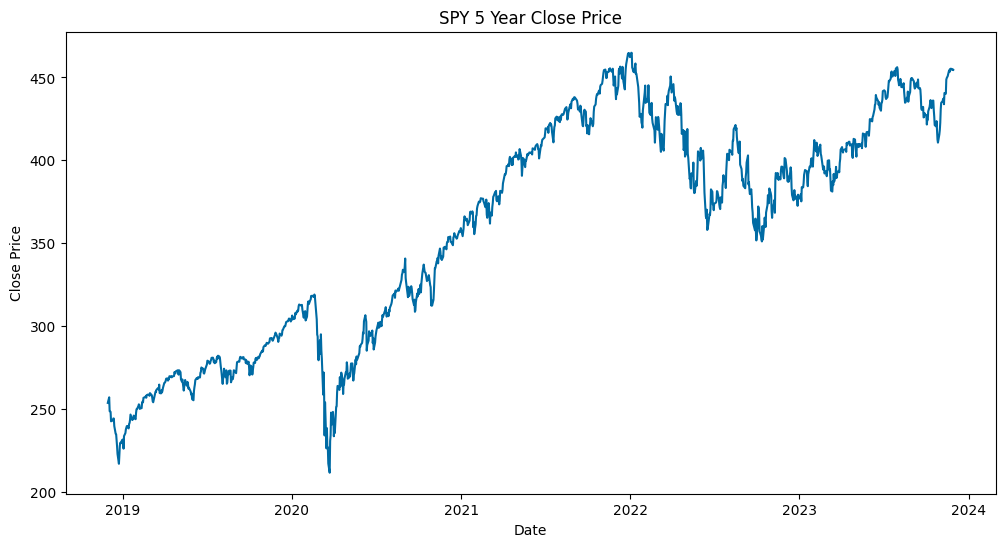

In [4]:
plt.style.use('tableau-colorblind10') #https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.figure(figsize=(12, 6))
close = aapl.history(period='5y')['Close']
plt.plot(close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY 5 Year Close Price')
plt.show()

## Check stationarity

### Split Price into halves for statistical analysis

In [5]:
X = close.copy()
split = round(len(X)/2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
mean_percent_diff = (mean2 - mean1) / mean1 * 100
var1, var2 = X1.var(), X2.var()
var_percent_diff = (var2 - var1) / var1 * 100
print('mean1=%f, mean2=%3f, mean_percent_diff=%f' % (mean1, mean2, mean_percent_diff))
print('variance1=%f, variance2=%f, var_percent_diff=%f' % (var1, var2, var_percent_diff))

mean1=302.223959, mean2=415.578712, mean_percent_diff=37.506872
variance1=2106.446491, variance2=690.814661, var_percent_diff=-67.204737


### Augmented Dickey-Fuller Test
##### Check for stationarity where H0 = time series !stationary; H1 = time series = stationary
##### If p-value <= .05 or abs(test statistic)>critical value, reject H0

In [6]:
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -1.407661
p-value: 0.578598
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


##### P-value > .05; therefore, time series is not stationary (as expected).
##### abs(ADF Statistic) < abs(critical value) -> fail to reject H0
##### Therefore: Time series is not stationary for p-values .01, .05, and .1

### Kwiatkowski-Phillips-Schmidt-Shin test
##### KPSS is opposite of ADF where H0 = time series = stationary; H1 = time series !stationary
##### If p-value <= .05 || abs(KPSS test statistic)>critical value -> reject H0 -> therefore, !stationary

In [7]:
result = kpss(X)
print(result)
print('KPSS Test Statistic: %.2f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[3])

(4.906238694717911, 0.01, 20, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS Test Statistic: 4.91
p-value: 0.010000
Critical Values:
{'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


##### P-value < .05; therefore, not stationary

### Transform into stationary series

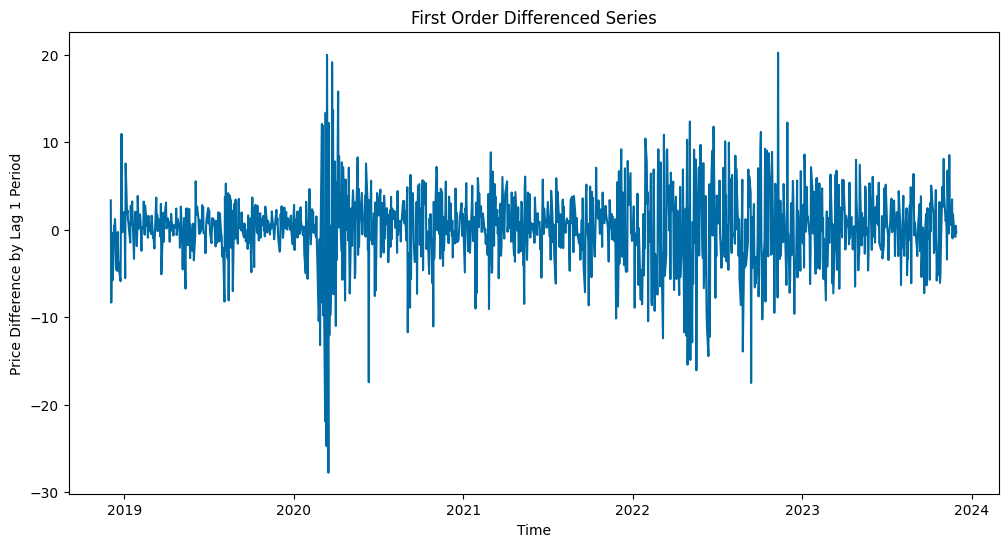

In [8]:
X['lag_1'] = X.diff() # periods=1 by default
X['lag_14'] = X.diff(periods=14) 
plt.figure(figsize=(12,6))
plt.plot(X['lag_1'])
plt.title('First Order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Price Difference by Lag 1 Period')
plt.show()

### X['lag_1'], therefore, is the first-ordered differenced stationary series to use.

In [9]:
ts_lag_1 = X.lag_1.dropna()
ts_lag_14 = X.lag_14.dropna()
result = adfuller(ts_lag_1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])

ADF Statistic: -10.915359
p-value: 0.000000
Critical Values:
{'1%': -3.4356048614183443, '5%': -2.8638605461891617, '10%': -2.5680054872544145}


(ADF) P-value < .05; therefore, AAPL price series is a difference-stationary series.

### Smoothing Methods
##### Reference
https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/

### Triple Exponential Smoothing
##### Use because we assume these time series have level, trends, seasonality, and noise
##### https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/

In [10]:
# Using method from Brownlee, J. (2020).
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

## Time Series Prediction
### Data partition
#### 2 years train; last 1 year validation

In [11]:
ts_lag_1 = ts_lag_1.asfreq('D')
ts_lag_1 = ts_lag_1.ffill()

past_year = ts_lag_1.iloc[-252:] # Typically 252 trading days per year
before_past_year = ts_lag_1.iloc[:-len(past_year)] # Beginning of selected time series until before 'past_year'

In [12]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]
close_valid = close.iloc[-252:]

## Simple Exponential forecaster
### Plot an initial time series
##### Reference: Module 1

In [13]:
# Forecast 12 months ahead
ses_model = SimpleExpSmoothing(close_train).fit()

ses_pred = ses_model.forecast(steps=len(close_valid))
print('AIC = %s' %(ses_model.aic))
print('BIC = %s' %(ses_model.bic))
ses_eval_metrics = ts_eval_metrics(close_valid, ses_pred)

AIC = 3043.950418432777
BIC = 3053.7759040737633
Time Series Evaluation Metrics
MSE = 1309.9724380304558
MAE = 29.8477273497439
RMSE = 36.19354138559055
MAPE = 0.06897249789753056
r2 = -1.4635326360442273



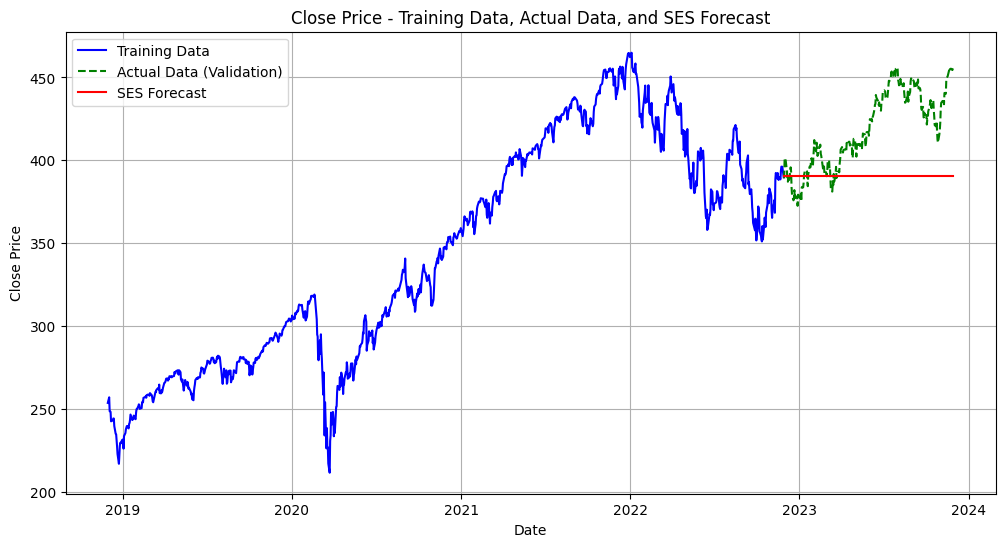

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, ses_pred, label='SES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and SES Forecast')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
#### WORKING IN PROGRESS to be investigate ######

# #impute
close = close.asfreq('D')
close = close.ffill()

## Decomposition of Raw Values

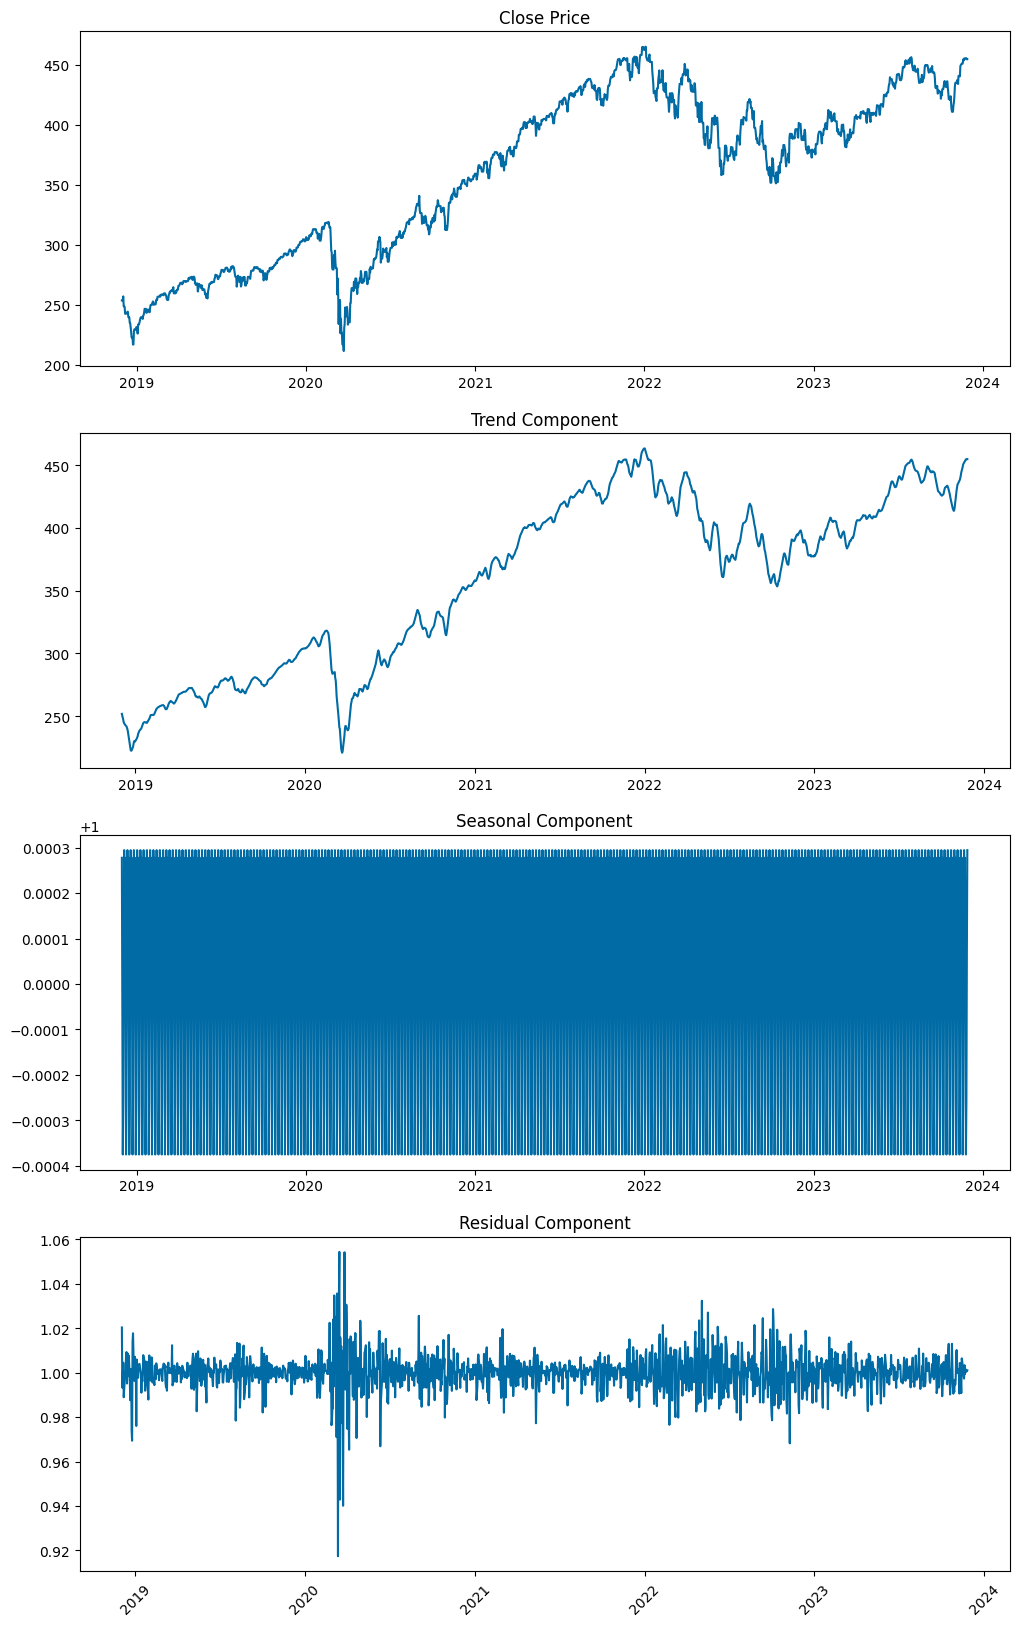

In [16]:
decomposition = seasonal_decompose(close, model='multiplicative')
#decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(close)
axs[1].plot(trend)
axs[2].plot(seasonal)
axs[3].plot(residual)

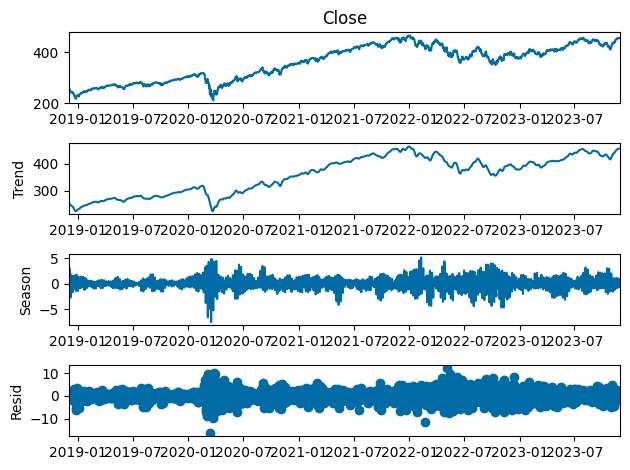

In [21]:
stl_close = STL(close)
stl_close_f = stl_close.fit()
stl_close_plot = stl_close_f.plot()

### Anomaly Detection from STL Decomposition

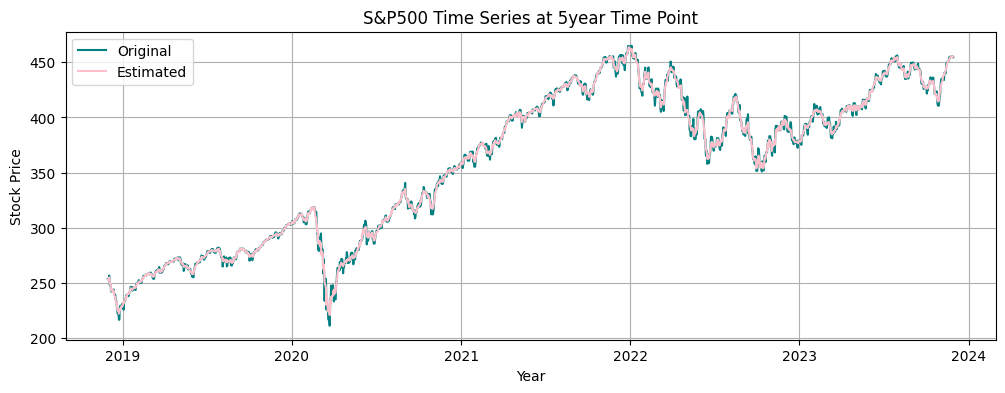

In [23]:
estimated0 = stl_close_f.trend + stl_close_f.seasonal
plt.figure(figsize=(12,4))
plt.plot(close, label='Original', color = 'teal')
plt.plot(estimated0, label ='Estimated', color = 'pink')


plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('S&P500 Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu0 = stl_close_f.resid.mean()
resid_dev0 = stl_close_f.resid.std()

lower0 = resid_mu0 - 3*resid_dev0
upper0 = resid_mu0 + 3*resid_dev0

Text(0.5, 1.0, 'S&P500 at 5year Time Point')

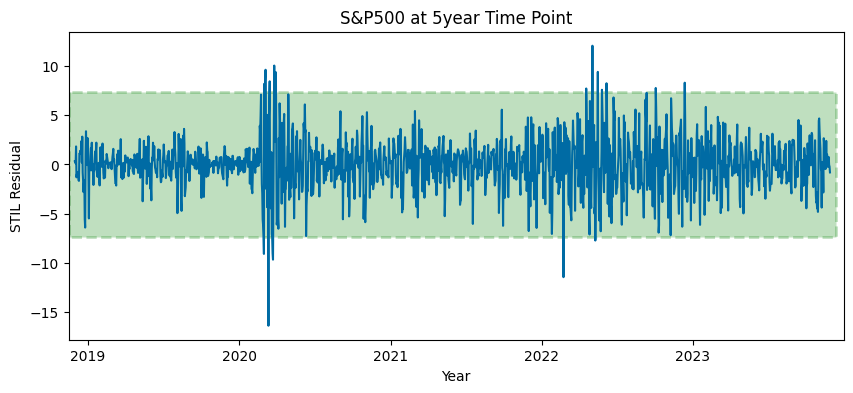

In [86]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(stl_close_f.resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower0, upper0, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,11,15), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('S&P500 at 5year Time Point')

In [35]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies0 = close[(stl_close_f.resid < lower0) | (stl_close_f.resid > upper0)]
anomalies0 = pd.DataFrame(anomalies0)

Text(0.5, 1.0, 'S&P500 at 5year Time Point')

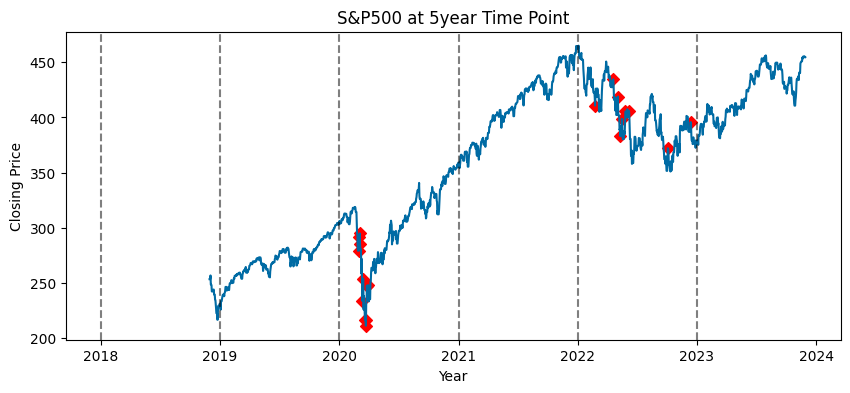

In [37]:
# Plot identified residual anomalies:    

plt.figure(figsize=(10,4))
plt.plot(close)

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies0.index, anomalies0.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('S&P500: Anomalies Marked at 3 Std. Dev or 99.7% within Normal Distribution ')

In [39]:
# Anomalies identified outside 3std dev of residuals: 

anomalies0.head()

,Close
Date,
2020-03-01 00:00:00-05:00,279.321075
2020-03-02 00:00:00-05:00,291.417511
2020-03-04 00:00:00-05:00,294.971954
2020-03-05 00:00:00-05:00,285.166595
2020-03-12 00:00:00-04:00,233.924072


### Gather parameters from decomposition

In [ ]:
stl_close.config, stl_close.period

## TO DO
### 1. Fit models to TREND and SEASON components
### 2. Make predictions with steps=len(close_valid) for each
### 3. Add these predictions to ARIMA predictions for FINAL prediction (sum of all components)

In [ ]:
# Trend model for trend time series 'trend' from Blk 16 above
# <code here>

# Season model for seasonal time series 'seasonal' from Blk 16 above
# <code here>

# Make predictions for each to be added to the ARIMA residual predictions
# <code here>

### Autocorrelation - Raw Values

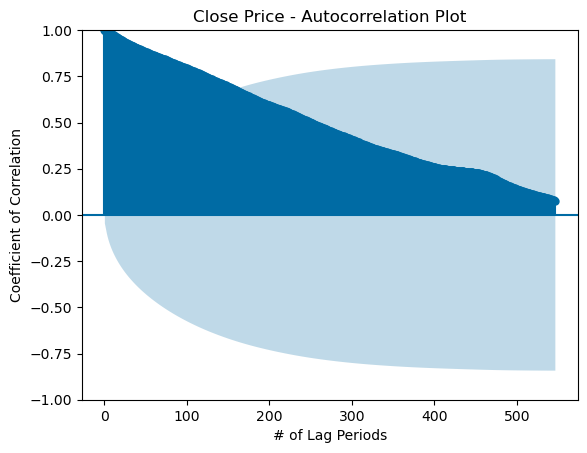

In [18]:
plot_acf(close, lags=546)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Partial Autocorrelation Plot - Raw Values

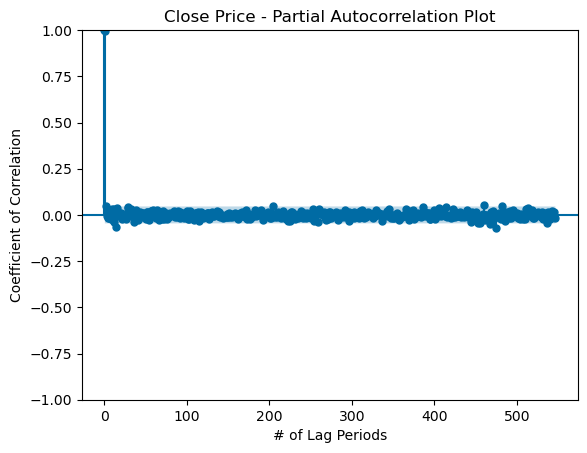

In [19]:
plot_pacf(close, lags=546)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR model with lags 1, 2 ~415, ~485, ~510.

## Lag_1 Decomposition

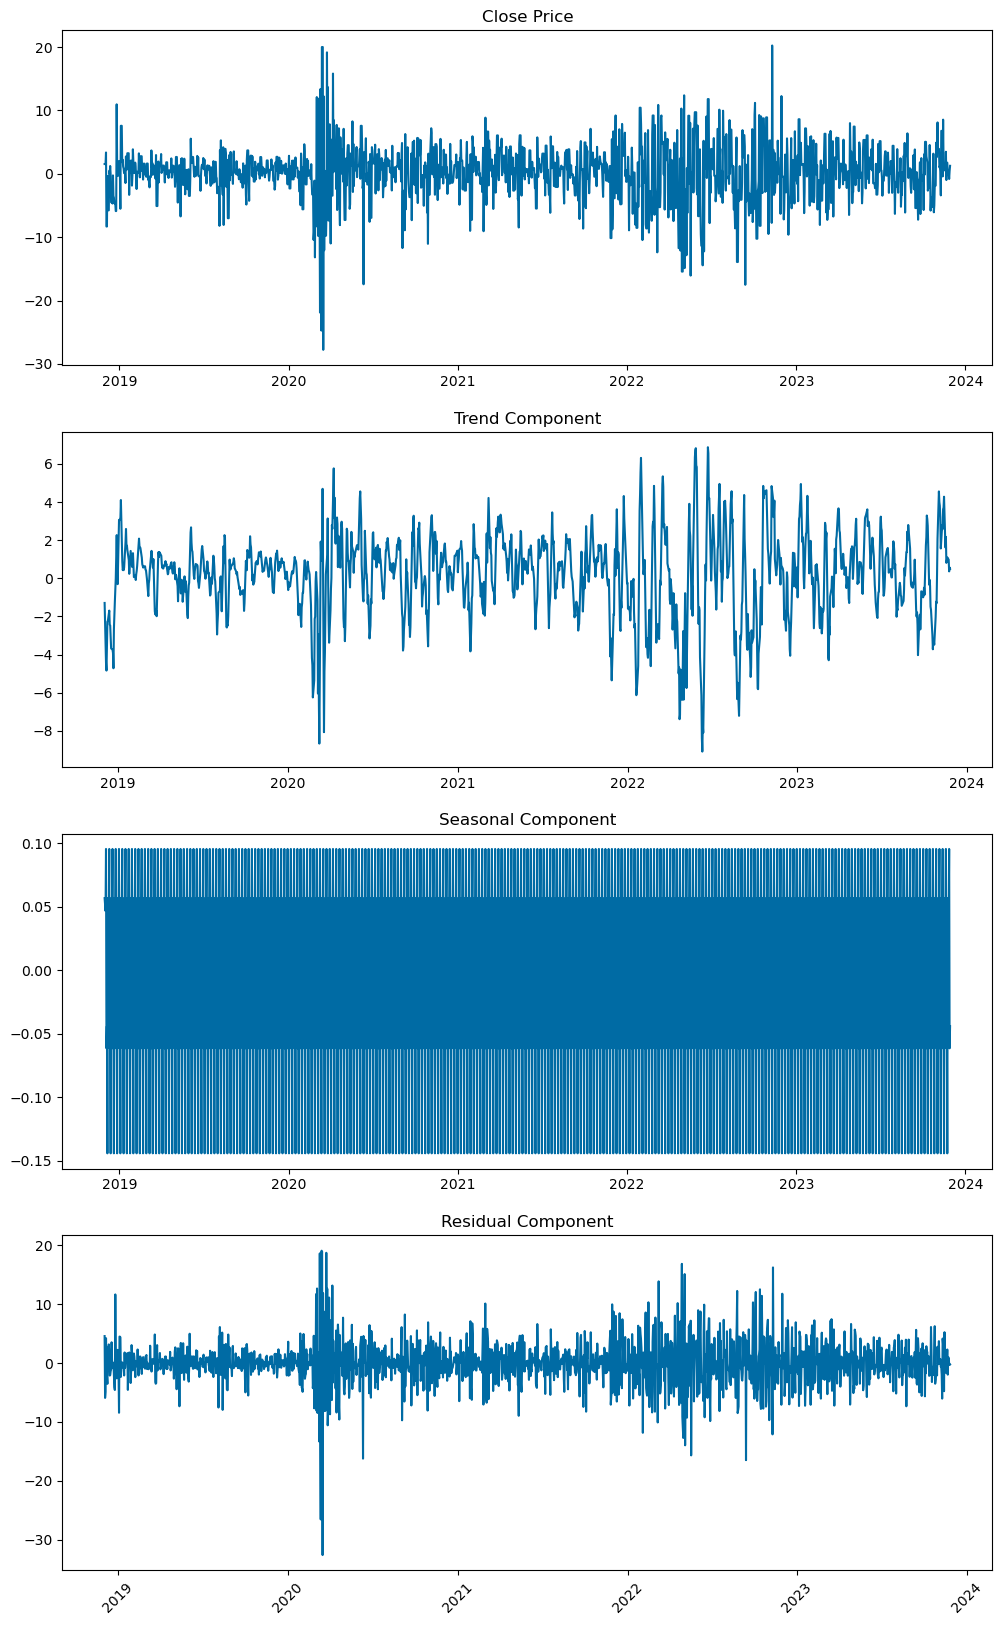

In [20]:
decomposition_lag_1 = seasonal_decompose(ts_lag_1, model='additive')
#decomposition.plot()

trend_lag_1 = decomposition_lag_1.trend
seasonal_lag_1 = decomposition_lag_1.seasonal
residual_lag_1 = decomposition_lag_1.resid

fig, axs = plt.subplots(4)
fig.set_figheight(20)
fig.set_figwidth(12)
plt.xticks(rotation=45)
axs[0].title.set_text('Close Price')
axs[1].title.set_text('Trend Component')
axs[2].title.set_text('Seasonal Component')
axs[3].title.set_text('Residual Component')
axs[0].plot(ts_lag_1)
axs[1].plot(trend_lag_1)
axs[2].plot(seasonal_lag_1)
axs[3].plot(residual_lag_1)

### Decompose using STL

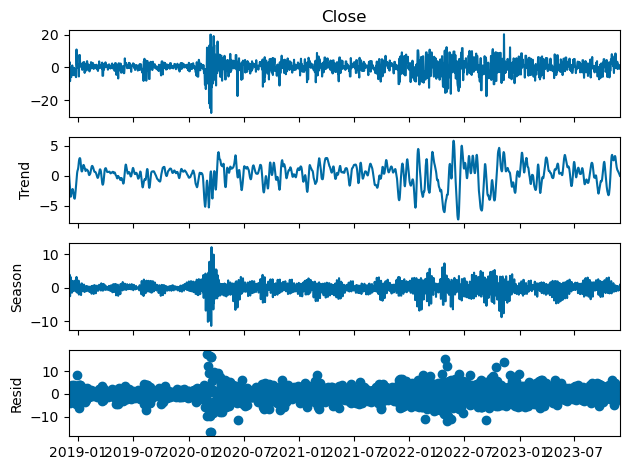

In [21]:
stl = STL(ts_lag_1)
stl_plot = stl.fit().plot()

In [22]:
stl.config, stl.period

({'period': 7,
  'seasonal': 7,
  'seasonal_deg': 1,
  'seasonal_jump': 1,
  'trend': 15,
  'trend_deg': 1,
  'trend_jump': 1,
  'low_pass': 9,
  'low_pass_deg': 1,
  'low_pass_jump': 1,
  'robust': False},
 7)

# ARIMA Parameter Selection
##### Reference: Shmueli, G. (2016). ARIMA models [Youtube Video]. https://www.youtube.com/watch?v=0xHf-SJ9Z9U&list=PLoK4oIB1jeK0LHLbZW3DTT05e4srDYxFq&index=29

### ACF on lag_1 period

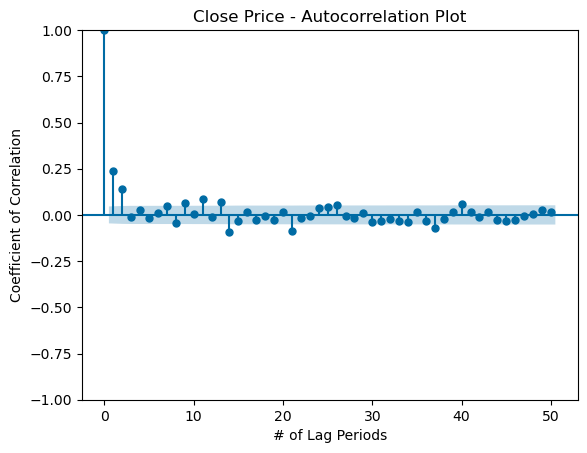

In [23]:
plot_acf(ts_lag_1, lags=50)  # Adjust the number of lags as needed
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Autocorrelation Plot')
plt.show()

### Therefore, based on ACF plot, we may want to do MA at 0, 1, 2, 11, 13, 14, 21, 37, 40.

### Plot PACF on lag_1 period

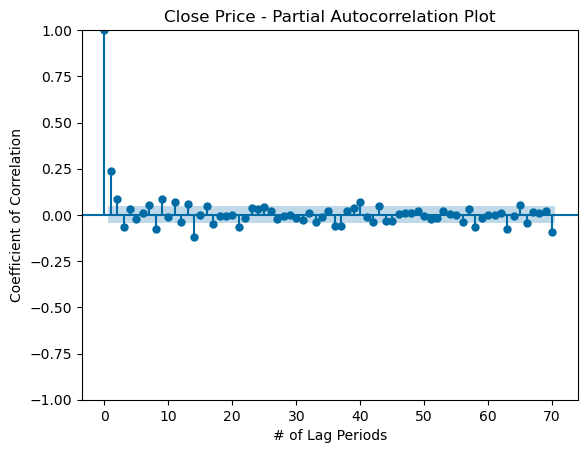

In [24]:
plot_pacf(ts_lag_1, lags=70)
plt.xlabel('# of Lag Periods')
plt.ylabel('Coefficient of Correlation')
plt.title('Close Price - Partial Autocorrelation Plot')
plt.show()

### Therefore, based on PACF plot, we may want to do AR at 1, 2, 3, 8, 9, 11, 14, and 21, 58, 63, 70.

In [25]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]#, 58, 63]#, 70] # based on PACF
#ar_orders = [58, 63]#, 70] # based on PACF # attempting higher order from PACF
ma_orders = [1, 2, 11, 13, 14, 21] # based on ACF
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(ar_order,1,1),trend='n') #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for AR(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

AIC for AR(1): 10455.620780689707
BIC for AR(1): 10472.148786487756


AIC for AR(2): 10443.92761765885
BIC for AR(2): 10465.964958722916


AIC for AR(3): 10438.68191008439
BIC for AR(3): 10466.228586414472


AIC for AR(8): 10430.141382684968
BIC for AR(8): 10485.234735345133


AIC for AR(9): 10417.990640461181
BIC for AR(9): 10478.593328387364


AIC for AR(11): 10412.767609628085
BIC for AR(11): 10484.388968086301


AIC for AR(14): 10382.164202542368
BIC for AR(14): 10470.313566798633


AIC for AR(21): 10379.889251477536
BIC for AR(21): 10506.603962595918




### Select AR(14) due to lowest AIC and BIC

### Rerun with AR(14) as default and iterate through different MA orders based on ACF

In [26]:
# Reference: ritvikmath (2020, Oct 7). Time series model selection (AIC & BIC): Time series talk [YouTube]. 
# https://www.youtube.com/watch?v=McEN54l3EPU

#ar_orders = [1, 2, 3, 8, 9, 11, 14, 21]
ar_orders = [0, 1, 2, 11, 13, 14, 21, 37, 40] #actually MA orders, but using same var name for simplicity
fitted_model_dict = {}
for i, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,ar_order)) #import statsmodels.api as sm for ARIMA
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
for ar_order in ar_orders:
    print('AIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].aic))
    print('BIC for MA(%s): %s' %(ar_order, fitted_model_dict[ar_order].bic))
    print('\n')
    

AIC for MA(0): 10486.967298071533
BIC for MA(0): 10569.607327061782


AIC for MA(1): 10382.164202542368
BIC for MA(1): 10470.313566798633


AIC for MA(2): 10411.192995613103
BIC for MA(2): 10504.851695135385


AIC for MA(11): 10374.84366068296
BIC for MA(11): 10518.086377599391


AIC for MA(13): 10369.117828820348
BIC for MA(13): 10523.379216268813


AIC for MA(14): 10372.76291410314
BIC for MA(14): 10532.533636817621


AIC for MA(21): 10376.784593486642
BIC for MA(21): 10575.120663063239


AIC for MA(37): 10364.691478453158
BIC for MA(37): 10651.17691228602


AIC for MA(40): 10368.076438336007
BIC for MA(40): 10671.08987796692




### AIC and BIC minimization suggest order=(14,1,1) is the optimal 3-tuple

### Measure error statistics on validation set

In [27]:
arima_model = sm.tsa.arima.ARIMA(ts_lag_1, order=(14,1,1)).fit() #import statsmodels.api as sm for ARIMA
print('AIC = %s' %(arima_model.aic))
print('BIC = %s' %(arima_model.bic))
arima_pred = arima_model.forecast(steps=len(close_valid))
arima_metrics = ts_eval_metrics(close_valid, arima_pred)

AIC = 10382.164202542368
BIC = 10470.313566798633
Time Series Evaluation Metrics
MSE = 175325.197105905
MAE = 418.08251605131767
RMSE = 418.71851774898255
MAPE = 0.9995086924962949
r2 = -328.42896159515163



### Interpretation: Even with minimum AIC and BIC, ARIMA optimal pdq based on ACF and PACF performs very poorly

## Attempt: Find optimal AES model parameters

In [28]:
#close_train = pd.DataFrame(close_train)
#close_train.reset_index(inplace=True)

In [29]:
#close_train.index

In [30]:
# Reference: https://www.statsmodels.org/stable/generated/
# statsmodels.tsa.holtwinters.ExponentialSmoothing.html#statsmodels.tsa.holtwinters.ExponentialSmoothing

aes_param_trend = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_damped_trend = [True, False]
aes_param_seasonal = ['add', 'mul', 'additive', 'multiplicative', None]
aes_param_seasonal_periods = [2, 3, 8, 9, 11, 14, 21, 58, 59, 60, 61, 62, 63, 64, 65, 70] # Informed by PACF
aes_param_initial_method = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied = [True, False]
fit_method = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict = {}

### Searching for ideal seasonal period parameter

In [31]:
for i in aes_param_seasonal_periods:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=True, #True, False
                                     seasonal= 'mul', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= i, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal Period 2
AIC = 3546.633945801941
BIC = 3581.030107256559
Time Series Evaluation Metrics
MSE = 1007.4576391836371
MAE = 25.952843487584175
RMSE = 31.74047320352419
MAPE = 0.06005788504328504
r2 = -0.892972199123742

Results for Seasonal Period 3
AIC = 3857.0172233358153
BIC = 3896.327122141093
Time Series Evaluation Metrics
MSE = 1001.4679367519373
MAE = 25.86895720946987
RMSE = 31.645978208169474
MAPE = 0.05986734658125234
r2 = -0.881717790260041

Results for Seasonal Period 8
AIC = 4434.210873795037
BIC = 4498.089459353612
Time Series Evaluation Metrics
MSE = 1668.9209192588853
MAE = 38.56328694943038
RMSE = 40.85242856010993
MAPE = 0.09264887283010494
r2 = -2.13583497689599

Results for Seasonal Period 9
AIC = 4452.87504781082
BIC = 4521.667370720056
Time Series Evaluation Metrics
MSE = 1760.348338221899
MAE = 39.53256750950263
RMSE = 41.956505314693445
MAPE = 0.09491593004863554
r2 = -2.307623403131822

Results for Seasonal Period 11
AIC = 4540.390479488083
BIC 

### Seasonal Periods at 2, 3, and 60 appear to be locally optimal candidate parameter values, but accounting for AIC and BIC, Seasonal Period 2 or 3 may be ideal.

### Searching for ideal seasonal parameter

In [32]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_seasonal:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= i, # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)


Results for Seasonal add
AIC = 3897.810622276691
BIC = 3932.206783731309
Time Series Evaluation Metrics
MSE = 1462.9280628503213
MAE = 33.25317631483299
RMSE = 38.24824261126675
MAPE = 0.07903960552473822
r2 = -1.748782722554581

Results for Seasonal mul
AIC = 3896.0694135254744
BIC = 3930.4655749800922
Time Series Evaluation Metrics
MSE = 1676.6439999236609
MAE = 35.733290381401225
RMSE = 40.94684358926413
MAPE = 0.08482536959683551
r2 = -2.150346333424942

Results for Seasonal additive
AIC = 3897.810622276691
BIC = 3932.206783731309
Time Series Evaluation Metrics
MSE = 1462.9280628503213
MAE = 33.25317631483299
RMSE = 38.24824261126675
MAPE = 0.07903960552473822
r2 = -1.748782722554581

Results for Seasonal multiplicative
AIC = 3896.0694135254744
BIC = 3930.4655749800922
Time Series Evaluation Metrics
MSE = 1676.6439999236609
MAE = 35.733290381401225
RMSE = 40.94684358926413
MAPE = 0.08482536959683551
r2 = -2.150346333424942

Results for Seasonal None
AIC = 4643.361405861524
BIC = 46

### Validation statistics suggest additive seasonality is optimal

### Searching for ideal trend parameter

In [33]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend=i, # 'add', 'mul', 'additive', 'multiplicative', None
                                     #damped_trend=True, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Trend %s' % (i))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Trend add
AIC = 3902.3667655235317
BIC = 3936.7629269781496
Time Series Evaluation Metrics
MSE = 830.9515700721266
MAE = 24.945447384726876
RMSE = 28.826230590767963
MAPE = 0.05979795002429748
r2 = -0.5613244267415225

Results for Trend mul
AIC = 3897.810303314916
BIC = 3932.206464769534
Time Series Evaluation Metrics
MSE = 1462.939498939239
MAE = 33.25331666215497
RMSE = 38.248392109201646
MAPE = 0.07903993402710302
r2 = -1.748804210503598

Results for Trend additive
AIC = 3902.3667655235317
BIC = 3936.7629269781496
Time Series Evaluation Metrics
MSE = 830.9515700721266
MAE = 24.945447384726876
RMSE = 28.826230590767963
MAPE = 0.05979795002429748
r2 = -0.5613244267415225

Results for Trend multiplicative
AIC = 3897.810303314916
BIC = 3932.206464769534
Time Series Evaluation Metrics
MSE = 1462.939498939239
MAE = 33.25331666215497
RMSE = 38.248392109201646
MAPE = 0.07903993402710302
r2 = -1.748804210503598

Results for Trend None
AIC = 3874.5702014448675
BIC = 3899.138888198

### Validation statistics suggest multiplicative trend is optimal

### Searching for ideal aes_param_damped_trend parameter

In [34]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_damped_trend:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=i, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method='heuristic'
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Damped Trend %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Damped Trend True
AIC = 3887.409981882209
BIC = 3926.7198806874867
Time Series Evaluation Metrics
MSE = 246.23733160054306
MAE = 13.562694699821083
RMSE = 15.691951172513349
MAPE = 0.03290457804798396
r2 = 0.5373300027940145

Results for Damped Trend False
AIC = 3897.810622276691
BIC = 3932.206783731309
Time Series Evaluation Metrics
MSE = 1462.9280628503213
MAE = 33.25317631483299
RMSE = 38.24824261126675
MAPE = 0.07903960552473822
r2 = -1.748782722554581



### Validation statistics suggest trend should be damped.

### Searching for optimal initialization method

In [35]:
close = aapl.history(period='5y')['Close']
close_train = close.iloc[:-len(past_year)]

for i in aes_param_initial_method:
    aes_model = ExponentialSmoothing(close_train, 
                                     trend='add', # 'add', 'mul', 'additive', 'multiplicative', None
                                     damped_trend=False, #True, False
                                     seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                     seasonal_periods= 3, 
                                     initialization_method=i
                                    ) #'estimated', 'heuristic', 'legacy-heuristic'
    aes_model = aes_model.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              #smoothing_seasonal=.1,
                              #damping_trend=.002
                             )
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model.aic))
    print('BIC = %s' %(aes_model.bic))
    aes_pred = aes_model.forecast(steps=len(close_valid))
    aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)

Results for Initialization Method None
AIC = 3913.1549091959805
BIC = 3947.5510706505984
Time Series Evaluation Metrics
MSE = 811.7350113583786
MAE = 24.619466635559615
RMSE = 28.49096367900494
MAPE = 0.05903878880070208
r2 = -0.5252172893362905

Results for Initialization Method estimated
AIC = 3896.973266398182
BIC = 3931.3694278528
Time Series Evaluation Metrics
MSE = 831.6903705355464
MAE = 24.957880006086924
RMSE = 28.839042469117217
MAPE = 0.059826903049903575
r2 = -0.5627126029620997

Results for Initialization Method heuristic
AIC = 3902.3668240730735
BIC = 3936.7629855276914
Time Series Evaluation Metrics
MSE = 830.949112144886
MAE = 24.945403364485923
RMSE = 28.82618795721845
MAPE = 0.059797846352457294
r2 = -0.5613198083955464

Results for Initialization Method legacy-heuristic
AIC = 3913.1549091959805
BIC = 3947.5510706505984
Time Series Evaluation Metrics
MSE = 811.7350113583786
MAE = 24.619466635559615
RMSE = 28.49096367900494
MAPE = 0.05903878880070208
r2 = -0.5252172893

### Validation statistics suggest initialization should be heuristic.

### Final pre-fit Advanced Exponential Smoothing Model w/ Parameters

In [36]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 3, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3892.365447597776
BIC = 3931.6753464030535
Time Series Evaluation Metrics
MSE = 378.22595361136837
MAE = 16.4058776654465
RMSE = 19.448032126962573
MAPE = 0.04012344992811824
r2 = 0.2893287148494381

None


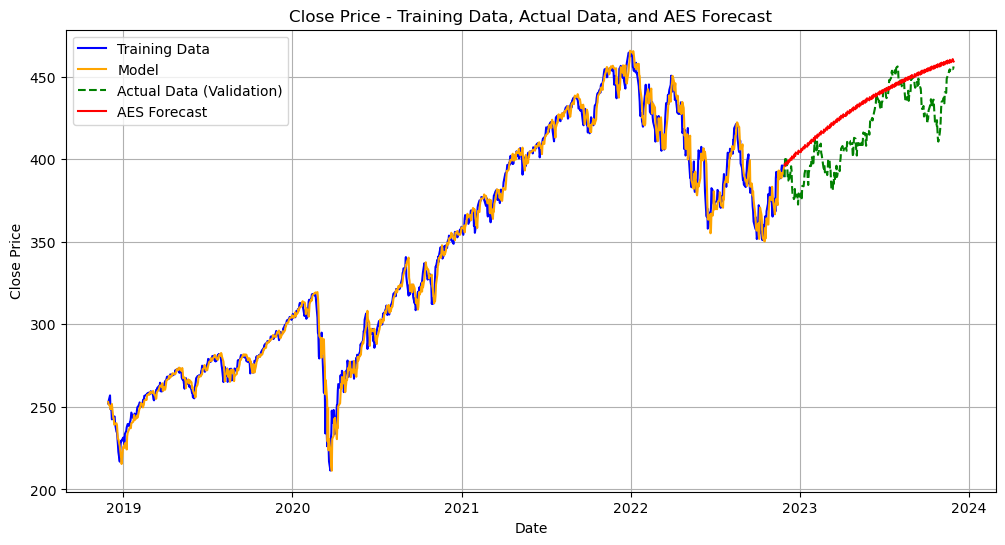

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

### Replicate the above, but with seasonal_periods=2 for lower AIC and BIC

In [38]:
aes_model = ExponentialSmoothing(close_train, 
                                 trend='mul', # 'add', 'mul', 'additive', 'multiplicative', None
                                 damped_trend=True, #True, False
                                 seasonal= 'add', # 'mul', 'additive', 'multiplicative', None
                                 seasonal_periods= 2, 
                                 initialization_method='heuristic') #'estimated', 'heuristic', 'legacy-heuristic'

aes_model = aes_model.fit(smoothing_level=.1, 
                          smoothing_trend=.1,
                          #smoothing_seasonal=.1,
                          #damping_trend=.002
                         )

aes_pred = aes_model.forecast(steps=len(close_valid))
print('AIC = %s' %(aes_model.aic))
print('BIC = %s' %(aes_model.bic))
aes_eval_metrics = ts_eval_metrics(close_valid, aes_pred)
print(aes_eval_metrics)

AIC = 3563.182440646611
BIC = 3597.578602101229
Time Series Evaluation Metrics
MSE = 397.70635670059005
MAE = 16.235902096196774
RMSE = 19.942576481001396
MAPE = 0.038059260386331256
r2 = 0.25272582452295045

None


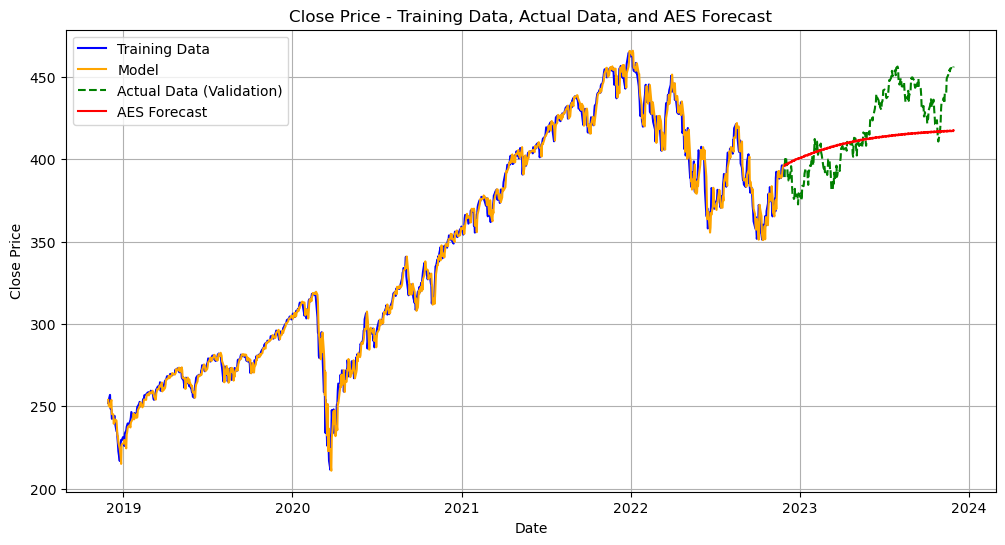

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(aes_model.fittedvalues, label="Model", color = 'orange')
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, aes_pred, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Autoregression Integrated Moving Average (ARIMA)
##### Reference:
##### Brownlee, J. (2020). How to create an ARIMA model for time series forecasting in Python. Machine Learning Mastery. https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python

In [40]:
# Auto regression integrated moving average; Find best (p,d,q) by using auto_arima function
# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average
# auto_arima_model = auto_arima(close_train, d=2, seasonal=True, stepwise=True, trace=True)
# auto_arima_model.summary()
# arima_pred = auto_arima_model.predict(n_periods=len(close_valid))
close_train = close_train.asfreq('D')
arima_model = sm.tsa.ARIMA(close_train, order=(14,1,1)).fit() #use '2' for quadratic trend
print(arima_model.summary())
arima_pred = arima_model.forecast(steps=len(close_valid))

# TO DO: ADD TREND AND SEASONAL FORECASTS TO ARIMA FORECAST (RESIDUAL COMPONENT) FOR FINAL FORECAST

# arima_eval_metrics = ts_eval_metrics(close_valid, arima_pred)
# print(arima_eval_metrics)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1461
Model:                ARIMA(14, 1, 1)   Log Likelihood               -2940.406
Date:                Wed, 29 Nov 2023   AIC                           5912.811
Time:                        11:24:51   BIC                           5997.390
Sample:                    11-29-2018   HQIC                          5944.362
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1889      1.068     -0.177      0.860      -2.283       1.905
ar.L2         -0.1160      0.157     -0.740      0.459      -0.423       0.191
ar.L3          0.1915      0.116      1.658      0.0

In [41]:
# auto_arima_model.plot_diagnostics(figsize=(12, 8))
# arima_pred.head

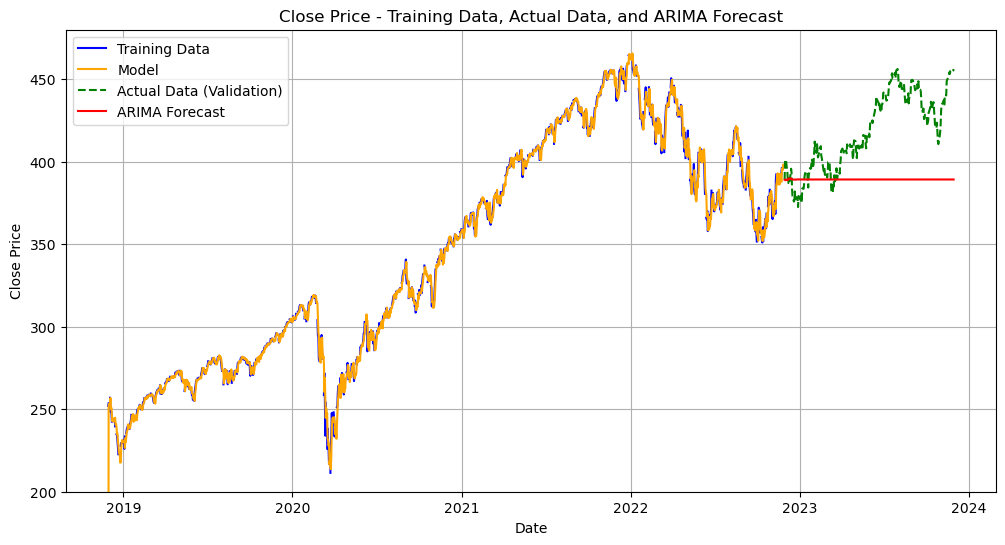

In [42]:
# plt.plot(close_valid.index, arima_pred, label="Predicted", color='red')
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_ylim([200, 480])
plt.plot(close_train, label='Training Data', color='blue')
plt.plot(arima_model.fittedvalues, label="Model", color = 'orange') # turn off it doesnt work
plt.plot(close_valid, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(close_valid.index, arima_pred, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

## Logistic Regression Model on SPY

### Add fields on open-close difference

In [43]:
hist = aapl.history(period = '1y')
# # hist = hist.diff()
# hist = hist.diff(periods=15)
# hist = hist.shift(3)
# hist = hist.dropna()
# hist['open_close'] = hist['Close'] - hist['Open']
# hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
# hist['high_low'] = hist['High'] - hist['Low']

# X = hist.drop(['positive'], axis =1)
# y = hist['positive']

# Add columns
hist['open_close'] = hist['Close'] - hist['Open']
hist['positive'] = np.where(hist['open_close'] > 0, 1, 0)
hist['high_low'] = hist['High'] - hist['Low']
hist = hist.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1) # Clean out sparse columns
hist.head()

,Open,High,Low,Close,Volume,open_close,positive,high_low
Date,,,,,,,,
2022-11-29 00:00:00-05:00,389.911913,391.142541,387.204534,389.104645,52310000,-0.807269,0,3.938007
2022-11-30 00:00:00-05:00,389.360556,401.361633,387.381728,401.361633,144566700,12.001078,1,13.979906
2022-12-01 00:00:00-05:00,402.434756,403.645704,398.477070,401.066315,76398200,-1.368442,0,5.168634
2022-12-02 00:00:00-05:00,396.015856,401.538896,395.907575,400.603638,85342700,4.587782,1,5.631322
2022-12-05 00:00:00-05:00,397.689477,398.654269,391.999058,393.397034,77289800,-4.292443,0,6.655211


In [44]:
hist_lag = hist.copy()

lag = 3

hist_lag = hist_lag.diff(periods=lag)
#for lag in range(1, 6):
#    globals()[f'hist_lag_{lag}'] = hist_lag.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_lag[lag_col_name] = hist_lag[col].shift(i)

hist_lag = hist_lag.dropna()
#hist_lag_1 = hist_lag_1.dropna() # Remove missing values due to lags out of range
#hist_lag_2 = hist_lag_2.dropna()
#hist_lag_3 = hist_lag_3.dropna()
#hist_lag_4 = hist_lag_4.dropna()
#hist_lag_5 = hist_lag_5.dropna()

In [45]:
pd.set_option('display.max_columns', 70)
display(hist_lag.head())
#display(hist_lag_1.head())
#display(hist_lag_2.head())
#display(hist_lag_3.head())

,Open,High,Low,Close,Volume,open_close,positive,high_low,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,open_close_lag1,positive_lag1,high_low_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,open_close_lag2,positive_lag2,high_low_lag2,Open_lag1_lag2,High_lag1_lag2,Low_lag1_lag2,Close_lag1_lag2,Volume_lag1_lag2,open_close_lag1_lag2,positive_lag1_lag2,high_low_lag1_lag2,Open_lag3,High_lag3,Low_lag3,Close_lag3,Volume_lag3,open_close_lag3,positive_lag3,high_low_lag3,Open_lag1_lag3,High_lag1_lag3,Low_lag1_lag3,Close_lag1_lag3,Volume_lag1_lag3,open_close_lag1_lag3,positive_lag1_lag3,high_low_lag1_lag3,Open_lag2_lag3,High_lag2_lag3,Low_lag2_lag3,Close_lag2_lag3,Volume_lag2_lag3,open_close_lag2_lag3,positive_lag2_lag3,high_low_lag2_lag3,Open_lag1_lag2_lag3,High_lag1_lag2_lag3,Low_lag1_lag2_lag3,Close_lag1_lag2_lag3,Volume_lag1_lag2_lag3,open_close_lag1_lag2_lag3,positive_lag1_lag2_lag3,high_low_lag1_lag2_lag3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-12 00:00:00-05:00,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205016,-9.854821,-12.906753,-13.339966,1574000.0,-4.134950,0.0,3.051932,8.328921,-2.707364,4.617330,-7.964600,-67276900.0,-16.293521,-1.0,-7.324695,6.103942,10.396356,8.703041,11.498993,33032700.0,5.395051,1.0,1.693314
2022-12-13 00:00:00-05:00,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205016,-9.854821,-12.906753,-13.339966,1574000.0,-4.134950,0.0,3.051932,8.328921,-2.707364,4.617330,-7.964600,-67276900.0,-16.293521,-1.0,-7.324695
2022-12-14 00:00:00-05:00,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205016,-9.854821,-12.906753,-13.339966,1574000.0,-4.134950,0.0,3.051932
2022-12-15 00:00:00-05:00,0.187053,-3.642673,-5.434443,-9.175568,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187
2022-12-16 00:00:00-05:00,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187053,-3.642673,-5.434443,-9.175568,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.

              precision    recall  f1-score   support

           0       0.55      0.73      0.63        15
           1       0.83      0.68      0.75        28

    accuracy                           0.70        43
   macro avg       0.69      0.71      0.69        43
weighted avg       0.73      0.70      0.70        43



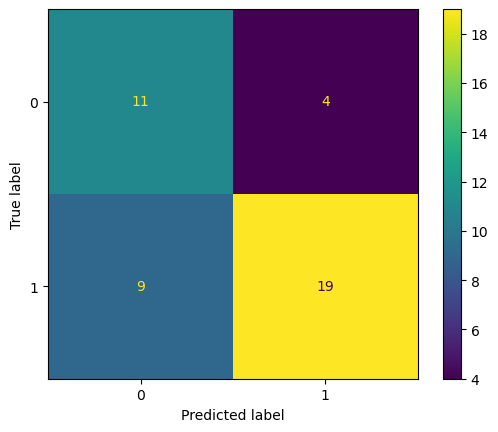

In [46]:
## Change n to lag the data
#for n in range(1, 6):  

# Data partition
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_lag.drop(['positive'], axis=1)
y = y.reindex(X.index)

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


# Model and fitting
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

# Model Performance  
logreg_pred = logreg_model.predict(X_valid) 
logreg_pred = pd.Series(logreg_pred, index=X_valid.index)
y_valid = y_valid.reindex(logreg_pred.index)
cm = confusion_matrix(y_valid, logreg_pred, labels=logreg_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
cmd.plot()
print(classification_report(y_valid, logreg_pred))

Lag = 1
              precision    recall  f1-score   support

           0       0.55      0.73      0.63        15
           1       0.83      0.68      0.75        28

    accuracy                           0.70        43
   macro avg       0.69      0.71      0.69        43
weighted avg       0.73      0.70      0.70        43



Lag = 2
              precision    recall  f1-score   support

           0       0.55      0.73      0.63        15
           1       0.83      0.68      0.75        28

    accuracy                           0.70        43
   macro avg       0.69      0.71      0.69        43
weighted avg       0.73      0.70      0.70        43



Lag = 3
              precision    recall  f1-score   support

           0       0.55      0.73      0.63        15
           1       0.83      0.68      0.75        28

    accuracy                           0.70        43
   macro avg       0.69      0.71      0.69        43
weighted avg       0.73      0.70      0.70   

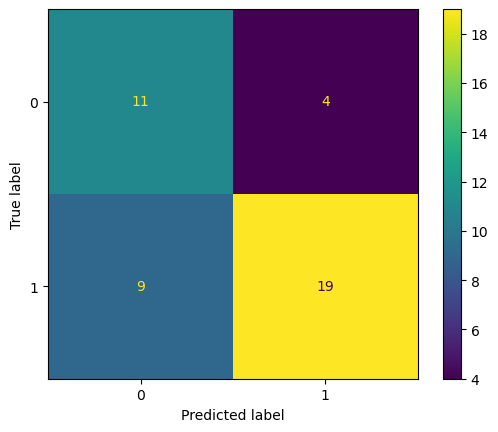

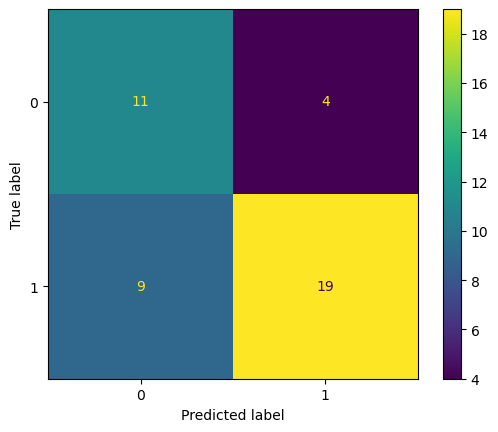

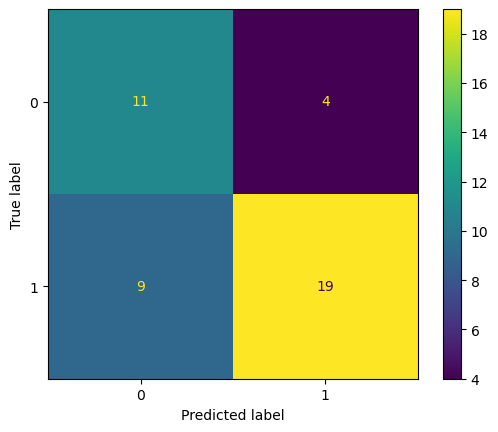

In [47]:
orders = [1,2,3] # hard-coded
log_fitted_model_dict = {}
logreg_pred_dict = {}
# Fit the models and instantiate each model individually
for i, order in enumerate(orders):
    logreg_model = LogisticRegression()
    logreg_model = logreg_model.fit(X_train,y_train)
    log_fitted_model_dict[order] = logreg_model
for order in orders:
    logreg_pred_dict[order] = log_fitted_model_dict[order].predict(X_valid) 
    logreg_pred_dict[order] = pd.Series(logreg_pred_dict[order], index=X_valid.index)
    cm = confusion_matrix(y_valid, logreg_pred_dict[order], labels=logreg_model.classes_)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
    print('Lag = %s' %(order))
    cmd.plot()
    print(classification_report(y_valid, logreg_pred_dict[order]))
    print('\n')

## Cross-sectional MLP (Neural Network) Model

Using cross-sectional since the dataframe that will be used already statically assigns the lagged values to its respective column. Shuffling across records does not dynamically change the values of the lagged columns.

### Make copy of historical data (differenced at lag=3)

In [48]:
hist_diff = hist.copy()
lag = 3
hist_diff = hist_diff.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_diff.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_diff[lag_col_name] = hist_diff[col].shift(i)

hist_diff = hist_diff.dropna() # Remove missing values due to lags out of range
hist_diff.head()

,Open,High,Low,Close,Volume,open_close,positive,high_low,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,open_close_lag1,positive_lag1,high_low_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,open_close_lag2,positive_lag2,high_low_lag2,Open_lag1_lag2,High_lag1_lag2,Low_lag1_lag2,Close_lag1_lag2,Volume_lag1_lag2,open_close_lag1_lag2,positive_lag1_lag2,high_low_lag1_lag2,Open_lag3,High_lag3,Low_lag3,Close_lag3,Volume_lag3,open_close_lag3,positive_lag3,high_low_lag3,Open_lag1_lag3,High_lag1_lag3,Low_lag1_lag3,Close_lag1_lag3,Volume_lag1_lag3,open_close_lag1_lag3,positive_lag1_lag3,high_low_lag1_lag3,Open_lag2_lag3,High_lag2_lag3,Low_lag2_lag3,Close_lag2_lag3,Volume_lag2_lag3,open_close_lag2_lag3,positive_lag2_lag3,high_low_lag2_lag3,Open_lag1_lag2_lag3,High_lag1_lag2_lag3,Low_lag1_lag2_lag3,Close_lag1_lag2_lag3,Volume_lag1_lag2_lag3,open_close_lag1_lag2_lag3,positive_lag1_lag2_lag3,high_low_lag1_lag2_lag3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-12 00:00:00-05:00,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205016,-9.854821,-12.906753,-13.339966,1574000.0,-4.134950,0.0,3.051932,8.328921,-2.707364,4.617330,-7.964600,-67276900.0,-16.293521,-1.0,-7.324695,6.103942,10.396356,8.703041,11.498993,33032700.0,5.395051,1.0,1.693314
2022-12-13 00:00:00-05:00,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205016,-9.854821,-12.906753,-13.339966,1574000.0,-4.134950,0.0,3.051932,8.328921,-2.707364,4.617330,-7.964600,-67276900.0,-16.293521,-1.0,-7.324695
2022-12-14 00:00:00-05:00,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187,-9.205016,-9.854821,-12.906753,-13.339966,1574000.0,-4.134950,0.0,3.051932
2022-12-15 00:00:00-05:00,0.187053,-3.642673,-5.434443,-9.175568,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.452694,-4.824091,-3.298096,-16551900.0,5.375371,1.0,-2.628603,-9.165736,-12.030610,-10.012423,-13.536926,-19414800.0,-4.371190,0.0,-2.018187
2022-12-16 00:00:00-05:00,-22.910593,-21.791772,-16.027942,-16.677490,-3924500.0,6.233103,0.0,-5.763830,0.187053,-3.642673,-5.434443,-9.175568,42300100.0,-9.362621,-1.0,1.791770,6.566610,7.757879,3.111030,6.025146,26663600.0,-0.541464,0.0,4.646849,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,14.846303,12.926542,5.710157,5.641235,63044600.0,-9.205067,-1.0,7.216385,1.151833,3.258681,1.417668,5.700256,9477900.0,4.548423,0.0,1.841013,-4.410619,-2.333305,1.486537,-0.541504,3475500.0,3.869115,0.0,-3.819842,-8.673467,-7.

### Preprocess dataframes for RobustScaler due to expected outlier stock price movements

In [49]:
hist_diff_scale = RobustScaler().fit_transform(hist_diff)
hist_diff_scale = pd.DataFrame(hist_diff_scale, columns=hist_diff.columns, index=hist_diff.index)

# Reset positive column to correct for differencing on all columns
hist_diff_scale['positive'] = hist['positive']
hist_diff_scale.head()

,Open,High,Low,Close,Volume,open_close,positive,high_low,Open_lag1,High_lag1,Low_lag1,Close_lag1,Volume_lag1,open_close_lag1,positive_lag1,high_low_lag1,Open_lag2,High_lag2,Low_lag2,Close_lag2,Volume_lag2,open_close_lag2,positive_lag2,high_low_lag2,Open_lag1_lag2,High_lag1_lag2,Low_lag1_lag2,Close_lag1_lag2,Volume_lag1_lag2,open_close_lag1_lag2,positive_lag1_lag2,high_low_lag1_lag2,Open_lag3,High_lag3,Low_lag3,Close_lag3,Volume_lag3,open_close_lag3,positive_lag3,high_low_lag3,Open_lag1_lag3,High_lag1_lag3,Low_lag1_lag3,Close_lag1_lag3,Volume_lag1_lag3,open_close_lag1_lag3,positive_lag1_lag3,high_low_lag1_lag3,Open_lag2_lag3,High_lag2_lag3,Low_lag2_lag3,Close_lag2_lag3,Volume_lag2_lag3,open_close_lag2_lag3,positive_lag2_lag3,high_low_lag2_lag3,Open_lag1_lag2_lag3,High_lag1_lag2_lag3,Low_lag1_lag2_lag3,Close_lag1_lag2_lag3,Volume_lag1_lag2_lag3,open_close_lag1_lag2_lag3,positive_lag1_lag2_lag3,high_low_lag1_lag2_lag3
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-12-12 00:00:00-05:00,0.039851,0.308146,0.037074,0.539039,0.362836,0.803149,1,0.668662,-0.622962,-0.424364,0.036418,-0.198111,0.183948,0.663874,0.0,-1.507730,-1.137924,-1.091814,-0.775841,-0.522718,-0.409522,0.899684,0.5,-1.027782,-1.162978,-1.669358,-1.420242,-1.711100,-0.489056,-0.718606,0.0,-0.775964,-1.162978,-1.669358,-1.420242,-1.711100,-0.489056,-0.718606,0.0,-0.775964,-1.146366,-1.368051,-1.763415,-1.675919,0.129862,-0.679590,0.0,1.139462,0.922629,-0.456495,0.446719,-1.032173,-1.918979,-2.640719,-0.5,-2.747288,0.647247,1.226344,0.956707,1.202513,1.043468,0.857976,0.5,0.605982
2022-12-13 00:00:00-05:00,1.720409,1.587453,0.593759,0.532069,1.959269,-1.588993,0,2.755541,0.058399,0.315600,0.027487,0.539039,0.362836,0.779832,0.0,0.692096,-0.619042,-0.420521,0.036131,-0.197753,0.186447,0.648515,0.0,-1.483167,-1.103799,-1.074992,-0.759030,-0.509222,-0.404171,0.891061,0.5,-1.003887,-1.103799,-1.074992,-0.759030,-0.509222,-0.404171,0.891061,0.5,-1.003887,-1.141725,-1.646707,-1.398302,-1.698908,-0.494715,-0.718606,0.0,-0.791485,-1.142768,-1.381250,-1.761490,-1.652016,0.129862,-0.667734,0.0,1.113090,0.904062,-0.451870,0.444465,-1.023916,-1.886049,-2.616838,-0.5,-2.739881
2022-12-14 00:00:00-05:00,0.704342,0.903506,0.256683,0.577408,0.875016,-0.082134,0,1.757971,1.735873,1.594908,0.584171,0.532069,1.959269,-1.567886,-0.5,2.780983,0.058031,0.312743,0.027270,0.538065,0.365064,0.761790,0.0,0.680855,-0.591329,-0.410326,0.045209,-0.185641,0.189641,0.642299,0.0,-1.448685,-0.591329,-0.410326,0.045209,-0.185641,0.189641,0.642299,0.0,-1.448685,-1.083556,-1.060407,-0.743806,-0.503850,-0.409522,0.891061,0.5,-1.023961,-1.138141,-1.662759,-1.396776,-1.674728,-0.494715,-0.706069,0.0,-0.773128,-1.119771,-1.367256,-1.752600,-1.638801,0.124725,-0.668864,0.0,1.110057
2022-12-15 00:00:00-05:00,-0.078545,-0.605082,-0.851563,-1.217791,1.341026,-1.616396,0,0.649544,0.721670,0.910961,0.247095,0.577408,0.875016,-0.089010,0.0,1.782453,1.724949,1.580465,0.579574,0.531108,1.959083,-1.531611,-0.5,2.735744,0.077376,0.315699,0.036432,0.547043,0.367613,0.754488,0.0,0.665026,0.077376,0.315699,0.036432,0.547043,0.367613,0.754488,0.0,0.665026,-0.579836,-0.404758,0.052265,-0.182105,0.186447,0.642299,0.0,-1.477642,-1.080155,-1.070457,-0.742994,-0.494070,-0.409522,0.875516,0.5,-1.000219,-1.115237,-1.645912,-1.389727,-1.661331,-0.488248,-0.706714,0.0,-0.771060
2022-12-16 00:00:00-05:00,-2.913043,-3.006676,-2.225414,-2.103766,-0.036592,1.096165,0,-2.283764,-0.059780,-0.597627,-0.861151,-1.217791,1.341026,-1.594780,-0.5,0.672960,0.717129,0.902711,0.245151,0.576366,0.876470,-0.086951,0.0,1.753466,1.723693,1.570908,0.583476,0.540115,1.955866,-1.516931,-0.5,2.672141,1.723693,1.570908,0.583476,0.540115,1.955866,-1.516931,-0.5,2.672141,0.077453,0.311416,0.043577,0.546422,0.365064,0.754488,0.0,0.678285,-0.578016,-0.408098,0.052208,-0.176202,0.186447,0.631094,0.0,-1.443391,-1.058417,-1.059612,-0.739244,-0.490117,-0.404638,0.854823,0.5,-0.997536


### Partition

In [50]:
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_diff_scale.drop(['positive'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

((200, 63), (43, 63), (200,), (43,))

### Cross-sectional MLP (Neural Network) Model Fitting and Confusion Matrix

##### Gridsearch for the best set of parameters

In [51]:
# Inspired by Deniega (2023) ADS 505 Final Project
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16, 
                           '(2,2)', '(3,3)', '(4,4)', '(5,5)', '(6,6)', '(7,7)', '(8,8)', '(9,9)', '(10,10)', 
                           '(2,2,2)', '(3,3,3)', '(4,4,4)', '(5,5,5)', '(6,6,6)', '(7,7,7)', '(8,8,8)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPClassifier(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnvincent/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/johnv

MLPClassifier(activation='logistic', hidden_layer_sizes=4, max_iter=500,
              random_state=14, solver='lbfgs')

##### Fit parameters to MLP model

In [52]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000, solver='sgd')
mlp_model.fit(X_train,y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000,
              solver='sgd')

##### Evaluate model with Confusion Matrix

              precision    recall  f1-score   support

           0       0.92      0.80      0.86        15
           1       0.90      0.96      0.93        28

    accuracy                           0.91        43
   macro avg       0.91      0.88      0.89        43
weighted avg       0.91      0.91      0.91        43



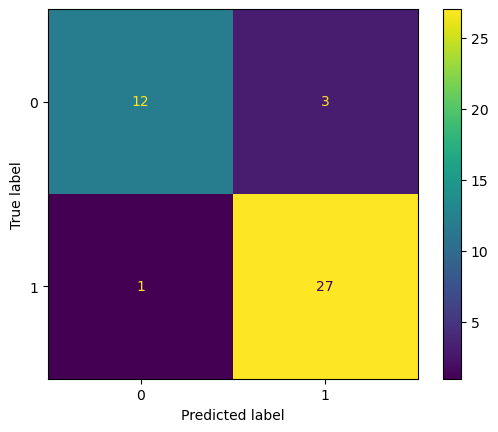

In [53]:
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

## TEST: Try different parameters (hidden layers, solvers, etc.) 

              precision    recall  f1-score   support

           0       0.93      0.87      0.90        15
           1       0.93      0.96      0.95        28

    accuracy                           0.93        43
   macro avg       0.93      0.92      0.92        43
weighted avg       0.93      0.93      0.93        43



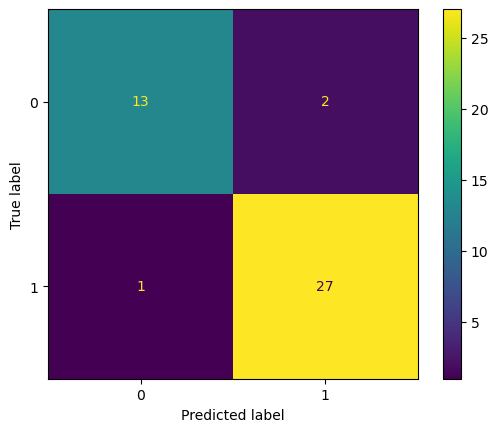

In [54]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(3,2), max_iter=4000, solver='sgd',
                         random_state=14)
mlp_model.fit(X_train,y_train)
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

##### Hidden Layers (3,2) shows .95 accuracy!!!

## Amazon  - Gabi in progress

In [3]:
# Download market data for Amazon: 

amzn = yf.Ticker("AMZN")
#amzn.history_metadata

In [4]:
# Import Amazon stock dataset: 

amzn = amzn.history(period="5y")
amzn_df = pd.DataFrame(amzn)

display(amzn_df.head(5))
display(amzn_df.tail(5))
display(amzn_df.describe())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-12-03 00:00:00-05:00,88.473000,88.917000,86.500000,88.617996,137246000,0.0,0.0
2018-12-04 00:00:00-05:00,87.800003,88.516998,83.250000,83.419998,173890000,0.0,0.0
2018-12-06 00:00:00-05:00,80.743500,85.052498,80.492500,84.959503,175788000,0.0,0.0
2018-12-07 00:00:00-05:00,85.253502,85.946503,81.273003,81.456497,151522000,0.0,0.0
2018-12-10 00:00:00-05:00,81.192001,82.899498,79.543503,82.051498,149896000,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-11-24 00:00:00-05:00,146.699997,147.199997,145.320007,146.740005,22378400,0.0,0.0
2023-11-27 00:00:00-05:00,147.529999,149.259995,146.880005,147.729996,53762400,0.0,0.0
2023-11-28 00:00:00-05:00,146.979996,147.600006,145.529999,147.029999,42711700,0.0,0.0
2023-11-29 00:00:00-05:00,147.850006,148.539993,145.970001,146.320007,40610900,0.0,0.0
2023-11-30 00:00:00-05:00,144.759995,146.929993,144.330002,146.089996,65757400,0.0,0.0


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1257.000000,1257.000000,1257.000000,1257.000000,1.257000e+03,1257.0,1257.000000
mean,126.587720,128.149086,124.913873,126.545998,7.755720e+07,0.0,0.015911
std,31.757874,32.042576,31.389924,31.676328,3.520614e+07,0.0,0.564108
min,67.300003,69.801498,65.349998,67.197998,1.762600e+07,0.0,0.000000
25%,94.902000,95.970001,93.739998,94.900497,5.402280e+07,0.0,0.000000
50%,125.070000,126.949997,123.849998,125.511002,6.695890e+07,0.0,0.000000
75%,158.350006,159.937500,156.250000,158.100494,9.079620e+07,0.0,0.000000
max,187.199997,188.654007,184.839493,186.570496,3.113460e+08,0.0,20.000000


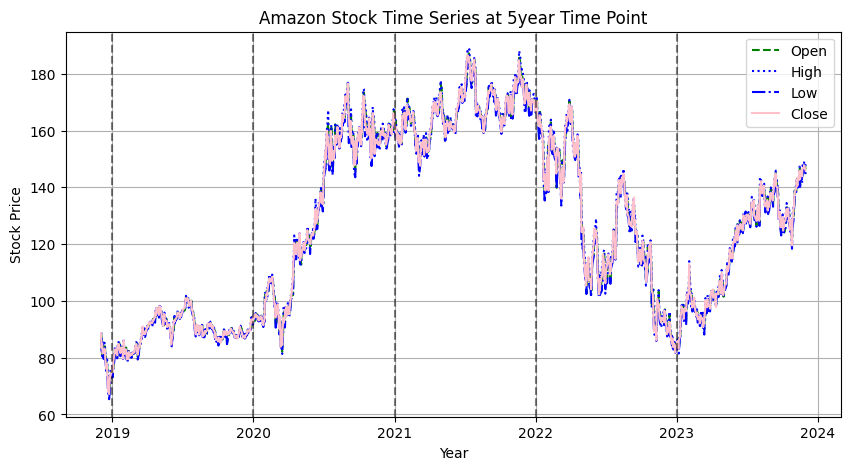

In [5]:
# Plot initial Amazon stock time series at 5y time point: 

plt.figure(figsize=(10, 5))
plt.plot(amzn_df['Open'], label='Open', color='green', linestyle='--')
plt.plot(amzn_df['High'], label='High', color='blue', linestyle='dotted')
plt.plot(amzn_df['Low'], label='Low', color='blue', linestyle='dashdot')
plt.plot(amzn_df['Close'], label='Close', color='pink')

for year in range(2019,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)

    
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

### Partition train and validation datasets 

In [6]:
# Partition train and validation datasets: 

past_year0 = amzn_df.iloc[-252:] # 252 trading days per year
b_past_year = amzn_df.iloc[:-len(past_year0)] 
                           
train = b_past_year['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.iloc[-len(past_year0):]
val_close = valid['Close'].asfreq('D')
val_close = val_close.ffill()

### Test of Stationarity

In [7]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(amzn_train )
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is not stationary')

ADF Statistic: -1.438395
p-value: 0.563737
Critical Values:
{'1%': -3.43484922137066, '5%': -2.8635271063560412, '10%': -2.5678279184465946}
Time series is not stationary


### STL Decoposition Using Locally Estimated Scatterplot Smoothing (LOESS)

In [8]:
# Fit close stock price dataset to STL: 

stl = STL(amzn_df['Close'], period=12)
result = stl.fit()


# Identify seasonal, trend, resid:

seasonal, trend, resid = result.seasonal, result.trend, result.resid

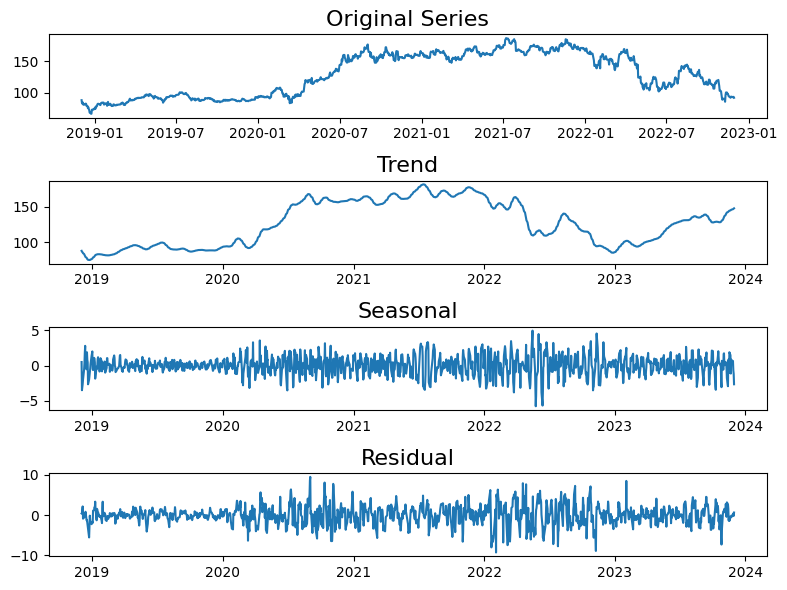

In [9]:
# Plot decomposition:

plt.figure(figsize=(8,6))

plt.subplot(4,1,1)
plt.plot(amzn_train)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Holt-Winters Smoothing

In [10]:
# Looking at overall trend with Holt's Winter Smoothing

hw_model = ExponentialSmoothing(amzn_train,
                    trend='add', seasonal='add', seasonal_periods=4)
result_hw = hw_model.fit()

amzn_smo_fore = amzn_train.copy()
amzn_smo_fore['Forecast'] = result_hw.fittedvalues
amzn_smo_fore = pd.to_numeric(amzn_smo_fore, errors='coerce')
amzn_smo_fore.dropna(inplace=True)

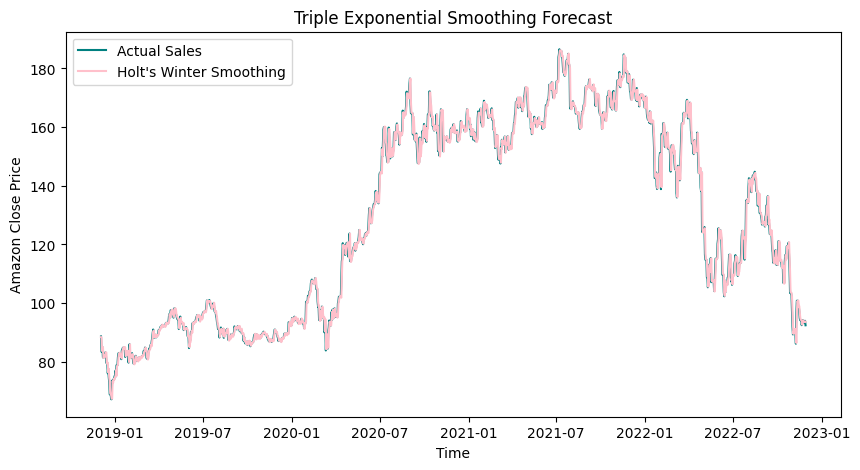

In [11]:
# Plot Holt's Winter Smoothing:

plt.figure(figsize=(10, 5))
plt.plot(amzn_smo_fore, label='Actual Sales', color = 'Teal', marker='')
plt.plot(result_hw.fittedvalues, label="Holt's Winter Smoothing", color = 'pink')
plt.xlabel('Time')
plt.ylabel('Amazon Close Price')
plt.title('Triple Exponential Smoothing Forecast')
plt.legend()
plt.show()

### Anomaly Detection

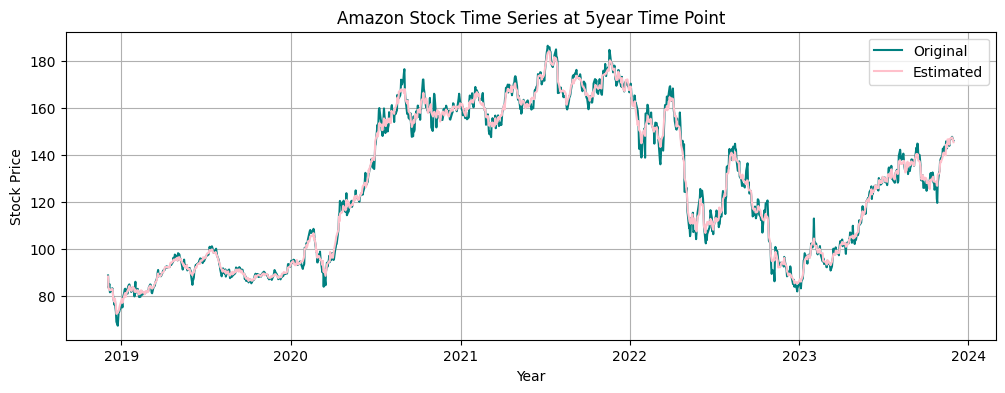

In [12]:
# Plot original Amazon Close time series vs Forecasted time series: 

estimated = trend + seasonal # from STL
plt.figure(figsize=(12,4))
plt.plot(amzn_df['Close'], label='Original', color = 'teal')
plt.plot(estimated, label ='Estimated', color = 'pink')

plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.title('Amazon Stock Time Series at 5year Time Point')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Taking residuals and detecting anomaly at 3std. dev: 

resid_mu = resid.mean()
resid_dev = resid.std()

lower = resid_mu - 3*resid_dev
upper = resid_mu + 3*resid_dev

Text(0.5, 1.0, 'Amazon at 5year Time Point')

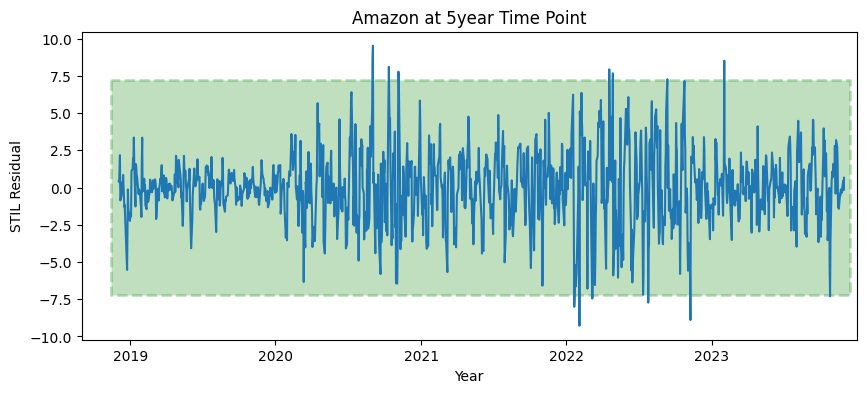

In [14]:
# Plot residual threshold: 

plt.figure(figsize=(10,4))
plt.plot(resid)

plt.fill_between([datetime(2018,11,15), datetime(2023,12,15)], lower, upper, color='g', alpha=0.25, linestyle='--', linewidth=2)
plt.xlim(datetime(2018,9,1), datetime(2024,1,1))

plt.xlabel('Year')
plt.ylabel('STIL Residual')
plt.title('Amazon at 5year Time Point')

In [15]:
# Identify anomalies by setting the residuals upper and lower limits:

anomalies = amzn_df['Close'][(resid < lower) | (resid > upper)]
anomalies = pd.DataFrame(anomalies)

Text(0.5, 1.0, 'Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')

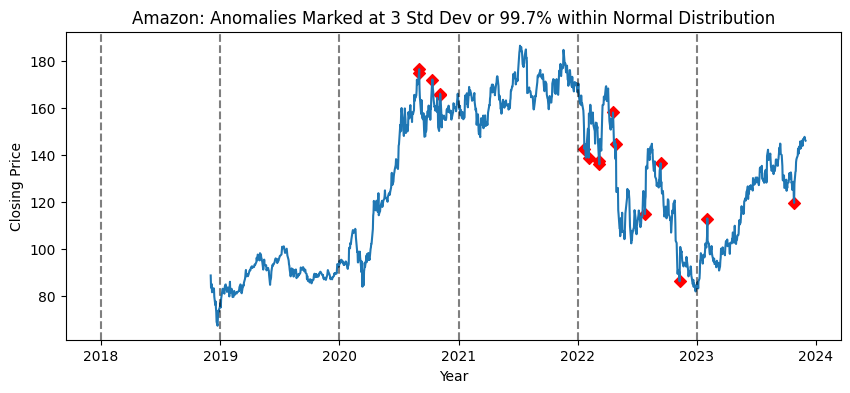

In [16]:
# Plot identified residual anomalies:    ********In Progress*******

plt.figure(figsize=(10,4))
plt.plot(amzn_df['Close'])

for year in range(2018,2024):
    plt.axvline(datetime(year,1,1), color='k', linestyle='--', alpha=0.5)
    
plt.scatter(anomalies.index, anomalies.Close, color='r', marker='D')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.title('Amazon: Anomalies Marked at 3 Std Dev or 99.7% within Normal Distribution')

In [17]:
# Anomalies identified outside 3std dev of residuals: 

anomalies.head()

,Close
Date,
2020-09-01 00:00:00-04:00,174.955994
2020-09-02 00:00:00-04:00,176.572495
2020-10-12 00:00:00-04:00,172.146500
2020-11-05 00:00:00-05:00,166.100006
2020-11-06 00:00:00-05:00,165.568497


### Transforming Time Series to Stationary

Text(0, 0.5, 'Amazon Stock Closing Price \n(First Diff.)')

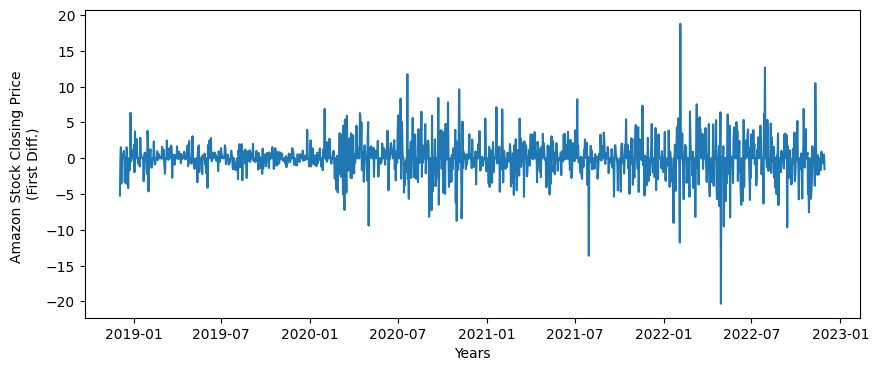

In [18]:
# Removing trend by applying the first Difference: 

diff_ts = amzn_train.diff().dropna()

# Plot first difference: 

plt.figure(figsize=(10,4))
plt.plot(diff_ts)

plt.xlabel('Years', fontsize=10)
plt.ylabel('Amazon Stock Closing Price \n(First Diff.)', fontsize=10)

In [19]:
# Determine dataset stationarity: 
# H0 = time series not stationary; H1 = time series is stationary

result = adfuller(diff_ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
print(result[4])
print('Time series is stationary')

ADF Statistic: -39.907192
p-value: 0.000000
Critical Values:
{'1%': -3.43484922137066, '5%': -2.8635271063560412, '10%': -2.5678279184465946}
Time series is stationary


### Selecting a Model

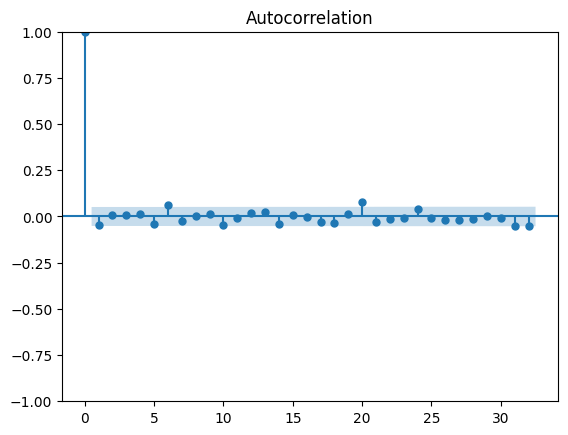

None

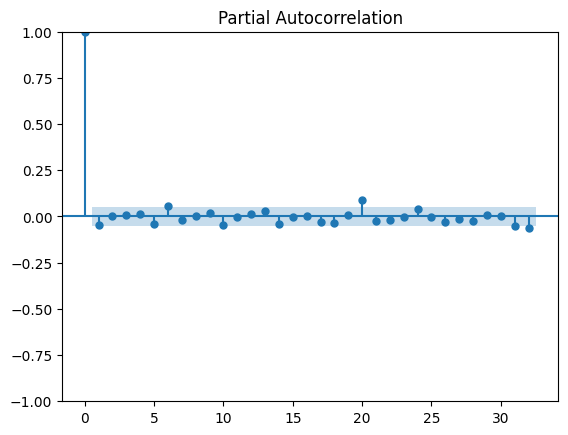

None

In [20]:
# ACF suggest MA Lag 1, 6, 10, 20, 31, 32 

plot_acf(diff_ts)
display(plt.show())

# PACF suggest AR Lag 1, 6, 10, 20, 31, 32

plot_pacf(diff_ts, method='ywm')
display(plt.show())

#### Model Selection Criteria: 

>BIC = $\ln(n)k$ - 2$l$
>
>AIC = 2$k$ - 2$l$


>($l$) = a log likelihood 
>
>($k$) = a number of parameters 
>
>($n$) = a number of samples used for fitting


#### Auto-ARIMA Model 

In [21]:
# Auto ARIMA Model: 

auto_arima_model = auto_arima(amzn_train, d=1, seasonal=True, stepwise=True, trace=True)
auto_arima_model.summary()

arima_pred0 = auto_arima_model.predict(n_periods=len(val_close))

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6726.057, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6725.221, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6725.256, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=6724.059, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6727.196, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.419 seconds


In [22]:
# ARIMA Model and Forecast at ARIMA(2,1,2): 

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m = sm.tsa.ARIMA(amzn_train, order=(2,1,2)).fit() 
print(arima_m.summary())

arima_pred1 = arima_m.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1458
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3354.073
Date:                Thu, 30 Nov 2023   AIC                           6718.145
Time:                        21:52:00   BIC                           6744.566
Sample:                    12-03-2018   HQIC                          6728.002
                         - 11-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5466      0.019    -28.858      0.000      -0.584      -0.509
ar.L2         -0.9611      0.017    -57.234      0.000      -0.994      -0.928
ma.L1          0.5231      0.017     30.780      0.0

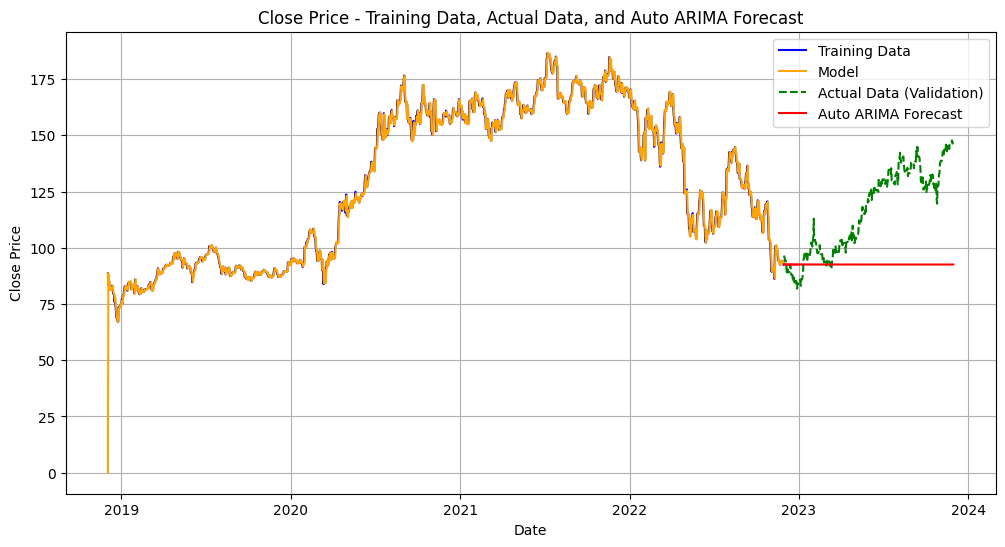

In [23]:
# Plot Auto ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m.fittedvalues, label="Model", color = 'orange') 
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred1, label='Auto ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and Auto ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

#### ARIMA Model

In [24]:
# AR lag optimization:

ar_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ar_order0 in enumerate(ar_orders0):
    ar_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(ar_order0,1,1),trend='n') 
    ar_model_fit0 = ar_model0.fit()
    fitted_model_dict[ar_order0] = ar_model_fit0

for ar_order0 in ar_orders0:
    print('AIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].aic))
    print('BIC for AR(%s): %s' %(ar_order0, fitted_model_dict[ar_order0].bic))
    print('\n')

AIC for AR(1): 6725.198133966253
BIC for AR(1): 6741.0505383848395


AIC for AR(6): 6727.159478252854
BIC for AR(6): 6769.432556702415


AIC for AR(10): 6731.263039979089
BIC for AR(10): 6794.672657653431


AIC for AR(20): 6732.196110490548
BIC for AR(20): 6848.447076226842


AIC for AR(31): 6741.239205125514
BIC for AR(31): 6915.615653729956


AIC for AR(32): 6738.22438959296
BIC for AR(32): 6917.884973003596




##### Result: 

AR order 1 has the lowest AIC and BIC scores. 

In [25]:
# MA lag optimization:

ma_orders0 = [1, 6, 10, 20, 31, 32]
fitted_model_dict = {}

for i, ma_order0 in enumerate(ma_orders0):
    ma_model0 = sm.tsa.arima.ARIMA(amzn_train, order=(1,1,ma_order0),trend='n') 
    ma_model_fit0 = ma_model0.fit()
    fitted_model_dict[ma_order0] = ma_model_fit0

for ma_order0 in ma_orders0:
    print('AIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].aic))
    print('BIC for AR(%s): %s' %(ma_order0, fitted_model_dict[ma_order0].bic))
    print('\n')

AIC for AR(1): 6725.198133966253
BIC for AR(1): 6741.0505383848395


AIC for AR(6): 6726.781449647218
BIC for AR(6): 6769.05452809678


AIC for AR(10): 6731.770970131172
BIC for AR(10): 6795.180587805515


AIC for AR(20): 6730.227970993255
BIC for AR(20): 6846.47893672955


AIC for AR(31): 6740.727384933941
BIC for AR(31): 6915.103833538383


AIC for AR(32): 6739.652614314502
BIC for AR(32): 6919.313197725139




##### Result: 

MA order 1 has the lowest AIC and BIC scores. 

In [26]:
# ARIMA Model and Forecast at ARIMA(1,1,1): 

# p = number of lag observations, lag order
# d = number of raw observations differenced, degree of differencing
# q = size of moving average window, order of moving average

arima_m0 = sm.tsa.ARIMA(amzn_train, order=(1,1,1)).fit() 
print(arima_m0.summary())

arima_pred2 = arima_m0.forecast(steps=len(val_close))

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1458
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3359.599
Date:                Thu, 30 Nov 2023   AIC                           6725.198
Time:                        21:52:45   BIC                           6741.051
Sample:                    12-03-2018   HQIC                          6731.112
                         - 11-29-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1244      0.588     -0.212      0.832      -1.277       1.028
ma.L1          0.0803      0.587      0.137      0.891      -1.071       1.231
sigma2         5.8931      0.106     55.834      0.0

In [27]:
# Statistical Metrics:

print('AIC = %s' %(arima_m0.aic))
print('BIC = %s' %(arima_m0.bic))
arima0_metrics = ts_eval_metrics(val_close, arima_pred2)

AIC = 6725.198133966253
BIC = 6741.0505383848395
Time Series Evaluation Metrics
MSE = 916.2370636550394
MAE = 24.792010072330044
RMSE = 30.269408049300193
MAPE = 0.19465341785954637
r2 = -1.5472265235981344



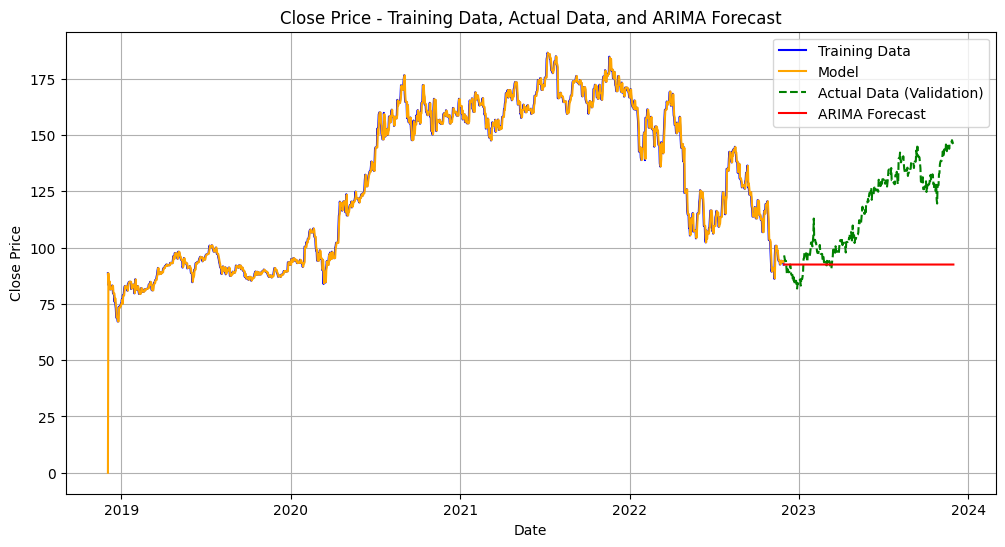

In [28]:
# Plot ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(arima_m0.fittedvalues, label="Model", color = 'orange') 
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, arima_pred2, label='ARIMA Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()

#### AES Model

In [46]:
# Define AES parameters for optimization:

aes_param_trend0 = ['add', 'mul', None]
aes_param_damped_trend0 = [True, False]
aes_param_seasonal0 = ['add', 'mul', None]
aes_param_seasonal_periods0 = [2, 6, 10, 20, 31, 32]
aes_param_initial_method0 = [None, 'estimated', 'heuristic', 'legacy-heuristic']

fit_param_smoothing_level0 = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_trend0 = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_smoothing_seasonal0 = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_param_damping_trend0 = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
fit_optimzied0 = [True, False]
fit_method0 = ['L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr', 'least_square']

fitted_model_dict0 = {}

In [47]:
# Seasonal period Optimization:

for i in aes_param_seasonal_periods0:
    aes_model0 = ExponentialSmoothing(amzn_train, 
                                     trend='mul', 
                                     damped_trend=True, 
                                     seasonal= 'mul', 
                                     seasonal_periods= i, # Error message: seasonal periods > 1
                                     initialization_method='heuristic'
                                    ) 
    aes_model0 = aes_model0.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              smoothing_seasonal=.1,
                              damping_trend=.002
                             )
    
    
    print('Results for Seasonal Period %s' % (i))
    print('AIC = %s' %(aes_model0.aic))
    print('BIC = %s' %(aes_model0.bic))
    aes_pred0 = aes_model0.forecast(steps=len(val_close))
    aes_eval_metrics0 = ts_eval_metrics(val_close, aes_pred0)

Results for Seasonal Period 2
AIC = 4416.303059990619
BIC = 4453.296806378599
Time Series Evaluation Metrics
MSE = 845.6029085368021
MAE = 23.633009334327838
RMSE = 29.07925220044013
MAPE = 0.18537852712893432
r2 = -1.3508568278870925

Results for Seasonal Period 6
AIC = 4776.033310215148
BIC = 4834.166340253402
Time Series Evaluation Metrics
MSE = 830.9863330756402
MAE = 23.399833362062314
RMSE = 28.826833559647863
MAPE = 0.18357440334642638
r2 = -1.3102213524454847

Results for Seasonal Period 10
AIC = 4868.155249091385
BIC = 4947.427562779913
Time Series Evaluation Metrics
MSE = 820.5552232503338
MAE = 23.22734847719045
RMSE = 28.645335104521536
MAPE = 0.18219986730929352
r2 = -1.2812218711195587

Results for Seasonal Period 20
AIC = 4919.930672168517
BIC = 5052.051194982732
Time Series Evaluation Metrics
MSE = 801.2450834718974
MAE = 22.975479831670707
RMSE = 28.306272864365194
MAPE = 0.180509035850871
r2 = -1.2275378387122649

Results for Seasonal Period 31
AIC = 5012.099450168225

##### Result: 

Seasonal period 2 has the lowest AIC and BIC scores. 

In [48]:
# Seasonal parameter optimization: 

for i in aes_param_seasonal0:
    aes_model1 = ExponentialSmoothing(amzn_train, 
                                     trend='mul', 
                                     damped_trend=True, 
                                     seasonal= i, 
                                     seasonal_periods= 2, 
                                     initialization_method='heuristic'
                                    ) 
    aes_model1 = aes_model1.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              smoothing_seasonal=.1,
                              damping_trend=.002
                             )
    
    
    print('Results for Seasonal %s' % (i))
    print('AIC = %s' %(aes_model1.aic))
    print('BIC = %s' %(aes_model1.bic))
    aes_pred1 = aes_model1.forecast(steps=len(val_close))
    aes_eval_metrics1 = ts_eval_metrics(val_close, aes_pred1)

Results for Seasonal add
AIC = nan
BIC = nan
Time Series Evaluation Metrics
MSE = 845.7474406913942
MAE = 23.635347286224704
RMSE = 29.081737236475302
MAPE = 0.18539708457255566
r2 = -1.3512586410774703

Results for Seasonal mul
AIC = 4416.303059990619
BIC = 4453.296806378599
Time Series Evaluation Metrics
MSE = 845.6029085368021
MAE = 23.633009334327838
RMSE = 29.07925220044013
MAPE = 0.18537852712893432
r2 = -1.3508568278870925

Results for Seasonal None
AIC = 4894.030701598195
BIC = 4920.4548061610385
Time Series Evaluation Metrics
MSE = 809.4495473388065
MAE = 23.051818119404913
RMSE = 28.450826830494865
MAPE = 0.18084361798460488
r2 = -1.250347031663186



##### Result: 

Seasonal parameter at mul (multiplicative) has the lowest AIC and BIC scores. 

In [55]:
# Trend parameter optimization:

for i in aes_param_trend0:
    aes_model2 = ExponentialSmoothing(amzn_train, 
                                     trend=i, 
                                     damped_trend=False, # Error message: Can only dampen the trend component
                                     seasonal= 'mul',
                                     seasonal_periods= 2, 
                                     initialization_method='heuristic'
                                    ) 
    aes_model2 = aes_model2.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              smoothing_seasonal=.1,
                              damping_trend=.002
                             )
    
    print('Results for Trend %s' % (i))
    print('AIC = %s' %(aes_model2.aic))
    print('BIC = %s' %(aes_model2.bic))
    aes_pred2 = aes_model2.forecast(steps=len(val_close))
    aes_eval_metrics2 = ts_eval_metrics(val_close, aes_pred2)

Results for Trend add
AIC = 4482.740645870268
BIC = 4514.44957134568
Time Series Evaluation Metrics
MSE = 8472.54459588825
MAE = 77.9866048173531
RMSE = 92.0464263069906
MAPE = 0.6196317643083672
r2 = -22.55448297509602

Results for Trend mul
AIC = 4477.711334807059
BIC = 4509.420260282471
Time Series Evaluation Metrics
MSE = 4727.657197855266
MAE = 59.07464754003361
RMSE = 68.75796097802251
MAPE = 0.47123113624473845
r2 = -12.143338429049296

Results for Trend None
AIC = 4410.475062484926
BIC = 4431.6143461352
Time Series Evaluation Metrics
MSE = 845.5944154880202
MAE = 23.63287351197073
RMSE = 29.07910616728135
MAPE = 0.18537746237806657
r2 = -1.3508332164005221



##### Result

No trend parameter has the lowest AIC and BIC scores. 

In [57]:
# Initialization method optimization:

for i in aes_param_initial_method0:
    aes_model3 = ExponentialSmoothing(amzn_train, 
                                     trend= None, 
                                     seasonal= 'mul', 
                                     seasonal_periods= 2, 
                                     initialization_method=i
                                    ) 
    aes_model3 = aes_model3.fit(smoothing_level=.1, 
                              smoothing_trend=.1,
                              smoothing_seasonal=.1,
                              damping_trend=.002
                             )
    
    print('Results for Initialization Method %s' % (i))
    print('AIC = %s' %(aes_model3.aic))
    print('BIC = %s' %(aes_model3.bic))
    aes_pred3 = aes_model3.forecast(steps=len(val_close))
    aes_eval_metrics3 = ts_eval_metrics(val_close, aes_pred3)

Results for Initialization Method None
AIC = 4410.4750623585505
BIC = 4431.614346008825
Time Series Evaluation Metrics
MSE = 845.5944154880201
MAE = 23.632873511970725
RMSE = 29.07910616728135
MAPE = 0.18537746237806654
r2 = -1.3508332164005217

Results for Initialization Method estimated
AIC = 4410.475062484926
BIC = 4431.6143461352
Time Series Evaluation Metrics
MSE = 845.5944154880202
MAE = 23.63287351197073
RMSE = 29.07910616728135
MAPE = 0.18537746237806657
r2 = -1.3508332164005221

Results for Initialization Method heuristic
AIC = 4410.475062484926
BIC = 4431.6143461352
Time Series Evaluation Metrics
MSE = 845.5944154880202
MAE = 23.63287351197073
RMSE = 29.07910616728135
MAPE = 0.18537746237806657
r2 = -1.3508332164005221

Results for Initialization Method legacy-heuristic
AIC = 4410.4750623585505
BIC = 4431.614346008825
Time Series Evaluation Metrics
MSE = 845.5944154880201
MAE = 23.632873511970725
RMSE = 29.07910616728135
MAPE = 0.18537746237806654
r2 = -1.3508332164005217



##### Result

No change or improvement in the model across different initialization method. 

In [ ]:
past_year0 = amzn_df.iloc[-252:] # 252 trading days per year
b_past_year = amzn_df.iloc[:-len(past_year0)] 
                           
train = b_past_year['Close'].asfreq('D')
amzn_train = train.ffill()

valid = amzn_df.iloc[-len(past_year0):]
val_close = valid['Close'].asfreq('D')
val_close = val_close.ffill()

In [121]:
# Final AES Model on train dataset: 

aes_modelf = ExponentialSmoothing(amzn_train, 
                                 trend= 'mul',
                                 seasonal= 'add', 
                                 seasonal_periods= 2) 

aes_modelf = aes_modelf.fit(smoothing_level=0, 
                              smoothing_trend=0
                              )


aes_predf = aes_modelf.forecast(steps=len(val_close))
aes_eval_metricsf = ts_eval_metrics(val_close, aes_predf)

print('AIC = %s' %(aes_modelf.aic))
print('BIC = %s' %(aes_modelf.bic))

Time Series Evaluation Metrics
MSE = 829.6554044812661
MAE = 23.427664399684474
RMSE = 28.80373941836834
MAPE = 0.18378243118878188
r2 = -1.3065212438697835

AIC = 3542.1965528781784
BIC = 3573.90547835359


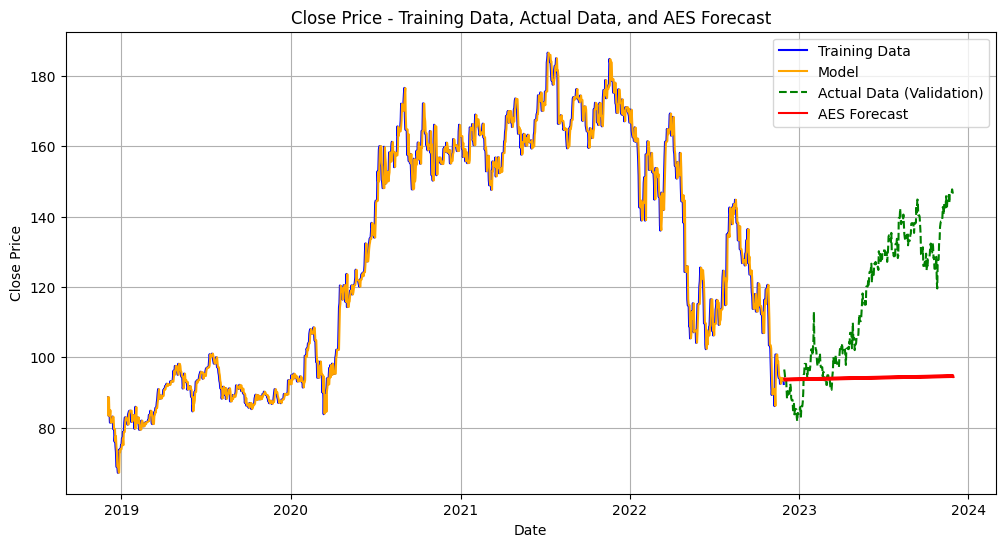

In [122]:
# Plot ARIMA Result:

plt.figure(figsize=(12, 6))
plt.plot(amzn_train, label='Training Data', color='blue')
plt.plot(aes_modelf.fittedvalues, label="Model", color = 'orange') 
plt.plot(val_close, label='Actual Data (Validation)', color='green', linestyle='--')
plt.plot(val_close.index, aes_predf, label='AES Forecast', color='red')

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price - Training Data, Actual Data, and AES Forecast')
plt.legend()
plt.grid(True)
plt.show()

#### Logistic Regression  **** IP

In [ ]:
#hist = aapl.history(period = '1y')

# # hist = hist.diff()
# hist = hist.diff(periods=15)
# hist = hist.shift(3)
# hist = hist.dropna()
# hist['open_close'] = hist['Close'] - hist['Open']
# hist['positive'] = np.where(hist['open_close'] >= 0, 1, 0)
# hist['high_low'] = hist['High'] - hist['Low']

# X = hist.drop(['positive'], axis =1)
# y = hist['positive']

# Add columns
hist['open_close'] = hist['Close'] - hist['Open']
hist['positive'] = np.where(hist['open_close'] > 0, 1, 0)
hist['high_low'] = hist['High'] - hist['Low']
hist = hist.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1) # Clean out sparse columns
hist.head()



In [ ]:
hist_lag = hist.copy()

lag = 3

hist_lag = hist_lag.diff(periods=lag)
#for lag in range(1, 6):
#    globals()[f'hist_lag_{lag}'] = hist_lag.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_lag.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_lag[lag_col_name] = hist_lag[col].shift(i)

hist_lag = hist_lag.dropna()
#hist_lag_1 = hist_lag_1.dropna() # Remove missing values due to lags out of range
#hist_lag_2 = hist_lag_2.dropna()
#hist_lag_3 = hist_lag_3.dropna()
#hist_lag_4 = hist_lag_4.dropna()
#hist_lag_5 = hist_lag_5.dropna()

In [ ]:
pd.set_option('display.max_columns', 70)
display(hist_lag.head())
#display(hist_lag_1.head())
#display(hist_lag_2.head())
#display(hist_lag_3.head())

In [ ]:
## Change n to lag the data
#for n in range(1, 6):  

# Data partition
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_lag.drop(['positive'], axis=1)
y = y.reindex(X.index)

end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]


# Model and fitting
logreg_model = LogisticRegression()
logreg_model.fit(X_train,y_train)

# Model Performance  
logreg_pred = logreg_model.predict(X_valid) 
logreg_pred = pd.Series(logreg_pred, index=X_valid.index)
y_valid = y_valid.reindex(logreg_pred.index)
cm = confusion_matrix(y_valid, logreg_pred, labels=logreg_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
cmd.plot()
print(classification_report(y_valid, logreg_pred))

In [ ]:
orders = [1,2,3] # hard-coded
log_fitted_model_dict = {}
logreg_pred_dict = {}
# Fit the models and instantiate each model individually
for i, order in enumerate(orders):
    logreg_model = LogisticRegression()
    logreg_model = logreg_model.fit(X_train,y_train)
    log_fitted_model_dict[order] = logreg_model
for order in orders:
    logreg_pred_dict[order] = log_fitted_model_dict[order].predict(X_valid) 
    logreg_pred_dict[order] = pd.Series(logreg_pred_dict[order], index=X_valid.index)
    cm = confusion_matrix(y_valid, logreg_pred_dict[order], labels=logreg_model.classes_)
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
    print('Lag = %s' %(order))
    cmd.plot()
    print(classification_report(y_valid, logreg_pred_dict[order]))
    print('\n')

#### Cross-sectional MLP (Neural Network)   ****IP

In [ ]:
hist_diff = hist.copy()
lag = 3
hist_diff = hist_diff.diff(periods=lag)

# Inspired by Deniega, J. (2023) ADS 505 Final Project
# Add lagged columns to same index
for i in range(1, lag+1):
    for col in hist_diff.columns:
        lag_col_name = f'{col}_lag{i}'
        hist_diff[lag_col_name] = hist_diff[col].shift(i)

hist_diff = hist_diff.dropna() # Remove missing values due to lags out of range
hist_diff.head()

In [ ]:
hist_diff_scale = RobustScaler().fit_transform(hist_diff)
hist_diff_scale = pd.DataFrame(hist_diff_scale, columns=hist_diff.columns, index=hist_diff.index)

# Reset positive column to correct for differencing on all columns
hist_diff_scale['positive'] = hist['positive']
hist_diff_scale.head()

In [ ]:
y = hist['positive'] # binary values should not be differenced]['positive'] # binary values should not be differenced
X = hist_diff_scale.drop(['positive'], axis=1)
y = y.reindex(X.index)

# Data partition
end_train_index = 200
X_train = X.iloc[:end_train_index]
X_valid = X.iloc[end_train_index:]

y_train = y.iloc[:end_train_index]
y_valid = y.iloc[end_train_index:]

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape #check lengths of data partitions

In [ ]:
# Inspired by Deniega (2023) ADS 505 Final Project
param_grid = {
    'hidden_layer_sizes': [1, 2, 4, 8, 16, 
                           '(2,2)', '(3,3)', '(4,4)', '(5,5)', '(6,6)', '(7,7)', '(8,8)', '(9,9)', '(10,10)', 
                           '(2,2,2)', '(3,3,3)', '(4,4,4)', '(5,5,5)', '(6,6,6)', '(7,7,7)', '(8,8,8)'],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': [500, 1000, 2000, 4000]
}

grid_search = GridSearchCV(MLPClassifier(random_state=14), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train,y_train)

best = grid_search.best_estimator_
best

In [ ]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=2, max_iter=2000, solver='sgd')
mlp_model.fit(X_train,y_train)

In [ ]:
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

In [ ]:
# Model and fitting
mlp_model = MLPClassifier(activation='tanh', hidden_layer_sizes=(3,2), max_iter=4000, solver='sgd',
                         random_state=14)
mlp_model.fit(X_train,y_train)
mlp_pred = mlp_model.predict(X_valid)
mlp_pred = pd.Series(mlp_pred, index=X_valid.index)
y_valid = y_valid.reindex(mlp_pred.index)
cm = confusion_matrix(y_valid, mlp_pred, labels=mlp_model.classes_)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp_model.classes_)
cmd.plot()
print(classification_report(y_valid, mlp_pred))

###### Code References: 
    
 https://github.com/ritvikmath/Time-Series-Analysis/blob/master/STL%20Decomposition.ipynb   
    